**Proyecto de Análisis de Ventas Multilocales**

---


**Contexto**:\
La cadena de tiendas "VentasExpress" opera en cinco ubicaciones distintas: Barcelona, Valencia, Pozuelo, Mallorca y
Malasaña. Como analista de datos recién contratado, se te ha asignado la tarea de realizar un análisis exhaustivo de las
operaciones de ventas en estas sucursales. Cada ubicación tiene su propio conjunto de datos, proporcionando información
detallada sobre transacciones, clientes y productos.


---


**Objetivo del Proyecto**:\
El objetivo principal es proporcionar a la empresa insights estratégicos a partir del análisis de datos de ventas. Se busca
comprender los patrones temporales, evaluar la efectividad de descuentos, comparar estrategias de precios entre ubicaciones
y destacar los productos más exitosos en diferentes intervalos temporales.


---


**Conjuntos de Datos**:
1. barcelona.xlsx: Datos de ventas de la sucursal en Barcelona.
2. valencia. xlsx : Datos de ventas de la sucursal en Valencia.
3. pozuelo. xlsx : Datos de ventas de la sucursal en Pozuelo.
4. mallorca. xlsx : Datos de ventas de la sucursal en Mallorca.
5. malasaña. xlsx : Datos de ventas de la sucursal en Malasaña.


---


**Instrucciones Adicionales**:

1.   Utiliza las funciones proporcionadas anteriormente para cargar datos y realizar operaciones específicas.
2.   Documenta cualquier limpieza de datos o manipulación realizada durante el análisis.
3. Organiza los resultados de manera clara y concisa en el informe final.
4. Personaliza el código según las necesidades específicas de tus datos y análisis.




## **IMPORTACION DE LIBRERIAS Y LIMPIEZA DEL DATASET**

In [ ]:
# LIBRERIAS

import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
from datetime import date, time, datetime
from google.colab import drive
drive.mount('/content/drive')

# CARGAR DATASETS

barcelona = pd.read_excel("/content/drive/MyDrive/datasets/barcelona.xlsx")
malasaña = pd.read_excel("/content/drive/MyDrive/datasets/malasaña.xlsx")
mallorca = pd.read_excel("/content/drive/MyDrive/datasets/mallorca.xlsx")
valencia = pd.read_excel("/content/drive/MyDrive/datasets/valencia.xlsx")
pozuelo = pd.read_excel("/content/drive/MyDrive/datasets/pozuelo.xlsx")


In [44]:
# LIMPIEZA

# Concatenamos todos los datasets en uno para facilitar trabajo
data = pd.concat([barcelona,malasaña,mallorca,valencia,pozuelo],axis=0,\
                 ignore_index=True)

# Quitamos espacios entre nombre de las variables
data = data.rename(columns=lambda x: x.replace(' ', ''))

# Eliminamos variables que contengan alta cantida de valores na
data.isnull().sum()
data.drop(["Cliente","CIF","CuentaContable","Ciudad","Provincia",\
          "Calle","CódigoPostal","GrupoMayor","Cód.Promoción","Cód.Descuento"],\
           axis=1, inplace=True)

# Eliminamos la variable No lo se
data = data[data["Producto"] != "No lo se"]

# Llenamos los valores na de columnas numericas con su media
data.fillna(data.mean(numeric_only=True), inplace=True)

# LLenamos los valores na de columnas no numericas con la moda
moda_dict = data.mode().iloc[0].to_dict()
data.fillna(moda_dict, inplace=True)

# Eliminamos caracteres innecesarios de variables
data.Local.unique()
data["Local"] = data.Local.str.replace(r" \(\✔\)", "", regex=True)

# Eliminamos valores fuera de lo comun (probablemente errores)
data = data.sort_values("Total", ascending=False)
data.drop(data.index[:5], inplace=True)

<ipython-input-44-a18701ab1636>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Preguntas de Análisis:


---


## 1. Análisis Temporal:
¿Cuál es el patrón temporal de las ventas en Barcelona, Valencia, Pozuelo, Mallorca y Malasaña a lo largo de los días y año?
¿Existen variaciones estacionales o eventos especiales que impacten significativamente las ventas en cada ubicación?

**Como hay que hacer analisis temporal desglosaremos primero la variable Fecha en año, nombre mes, nombre dia y hora de ventas**

In [45]:
data["año"] = data["Fecha"].dt.year
data["nombre_mes"] = data["Fecha"].dt.month_name()
data["nombre_dia"] = data["Fecha"].dt.day_name()
data["dia"] = data["Fecha"].dt.day
data["horaIncio"] = data.Fecha.dt.hour
data["hora"]= data["FechaCreación"].dt.hour

**Ahora procederemos a analizar la ventas por año**

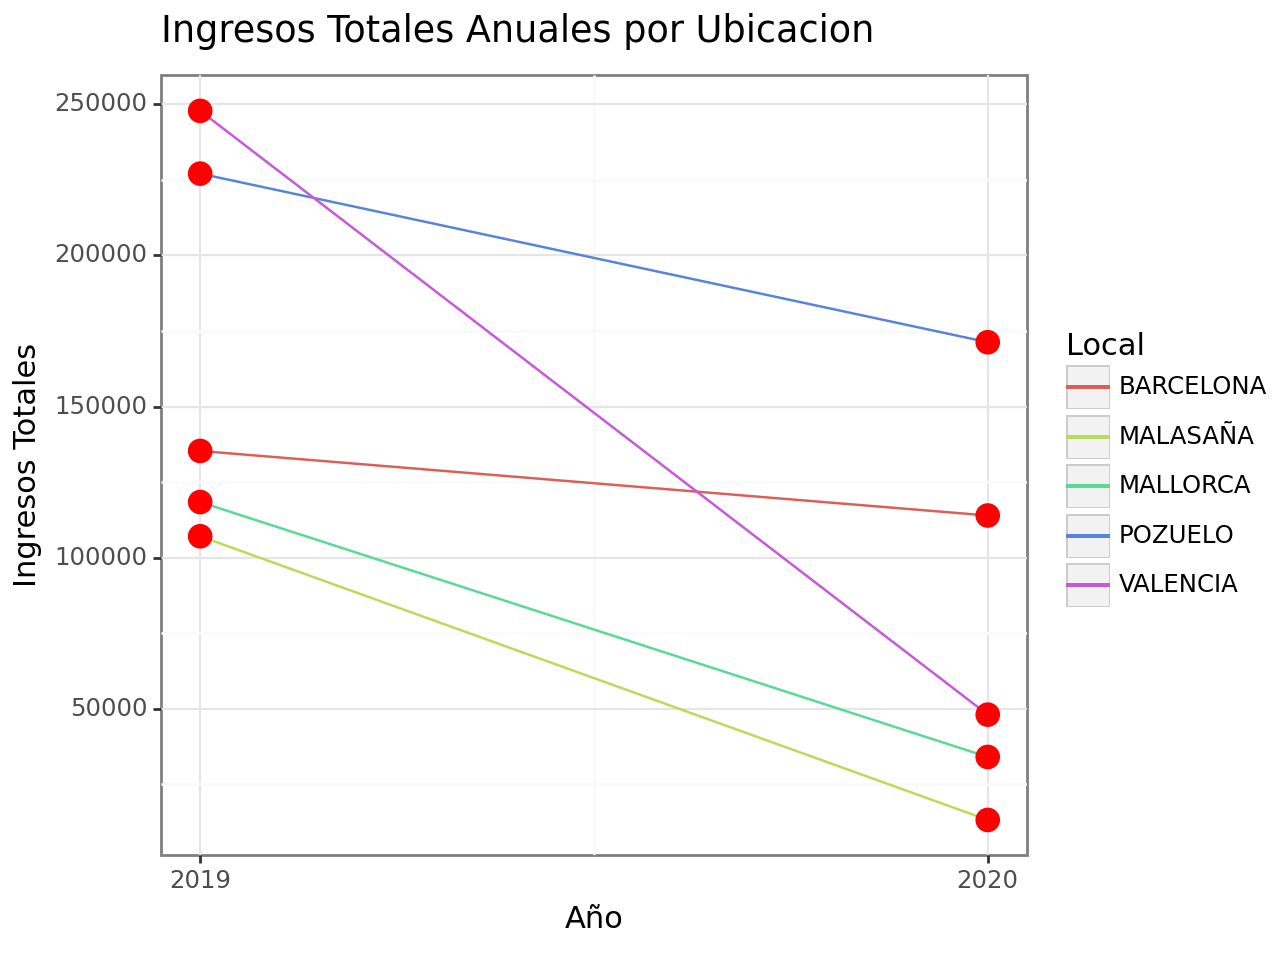

<Figure Size: (640 x 480)>

In [46]:
ventas_anuales = data.loc[:,["Local","Total","año"]]\
    .groupby(["Local","año"], as_index=False)\
        .agg(VentasTotales=("Total","sum"))

ggplot(aes("año","VentasTotales",color="Local"), ventas_anuales)\
    +geom_line()\
    +geom_point(size=4, color="red")\
    +scale_x_continuous(breaks=[2019, 2020])\
    +labs(title="Ingresos Totales Anuales por Ubicacion",
         x="Año",
         y="Ingresos Totales")\
    +theme_bw()


Con este grafico podemos observar como las ventas han disminuidos en todas las localidades del 2019 al 2020, esto es debido principalmente a la pandemia por COVID 19. La localidad mas afectada fue Valencia mientras la que se mantuvo mas estable fue Barcelona

Ahora procederemos a analizar las ventas totales mensuales y tambien las desglosaremos por años en diferente graficos para observarlo mejor

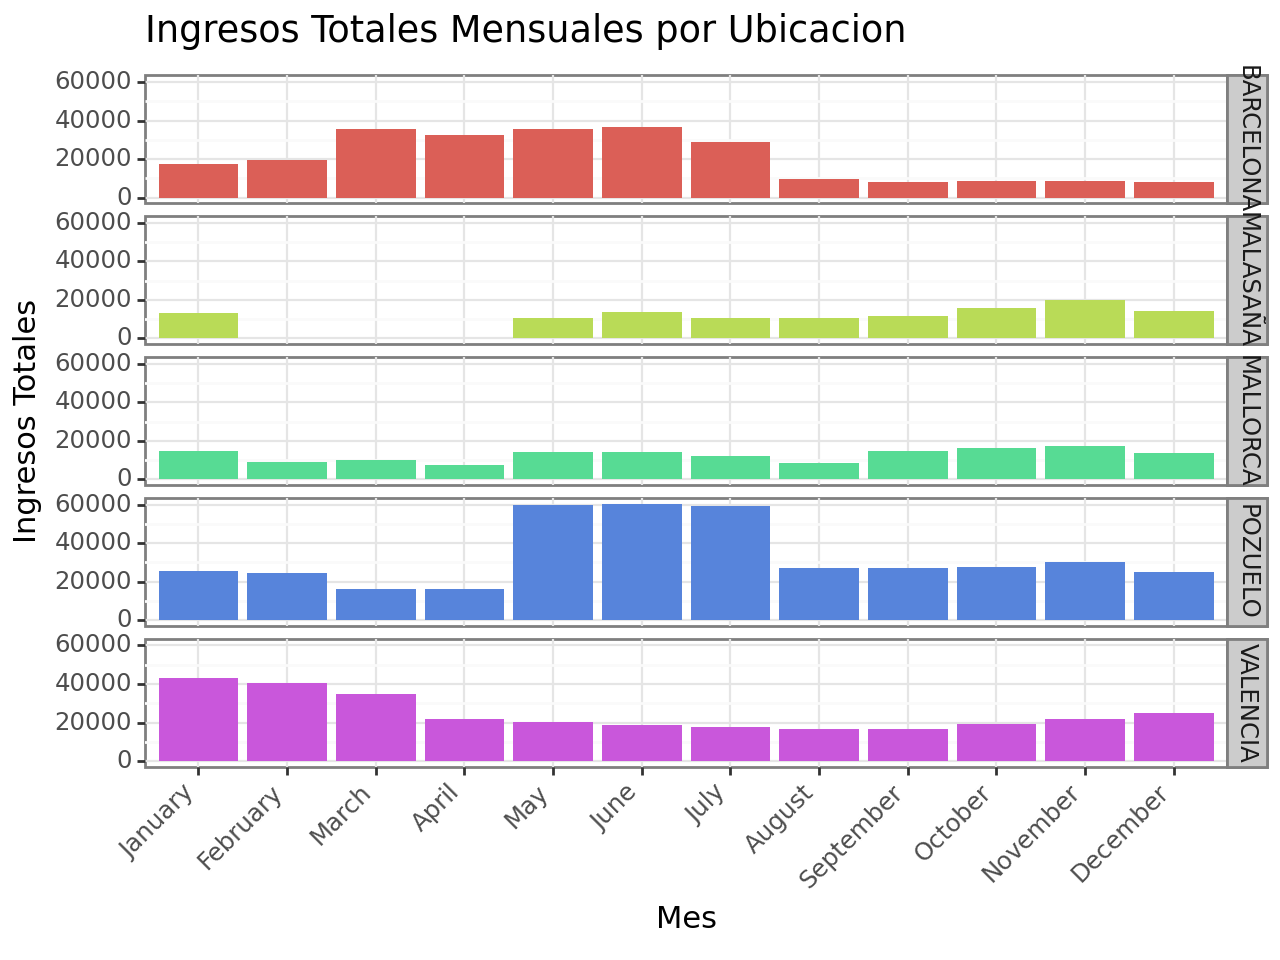

<Figure Size: (640 x 480)>

In [47]:
# Ventas por meses

ventas_mes = data.loc[:,["Local","Total","nombre_mes","año"]]\
    .groupby(["Local","nombre_mes","año"], as_index=False)\
        .agg(VentasTotales=("Total","sum"))

months_order = ["January", "February", "March", "April", "May", "June",\
              "July", "August", "September", "October", "November", "December"]

ventas_mes["nombre_mes"] = pd.Categorical(ventas_mes["nombre_mes"], \
                                          categories=months_order, ordered=True)

ggplot(aes("nombre_mes","VentasTotales",fill="Local"), ventas_mes)\
    +geom_bar(stat="identity")\
    +facet_grid("Local ~ .")\
    +labs(title="Ingresos Totales Mensuales por Ubicacion",
         x="Mes",
         y="Ingresos Totales")\
    +theme_bw()\
    +theme(legend_position="none")\
    +theme(axis_text_x=element_text(angle=45, hjust=1))

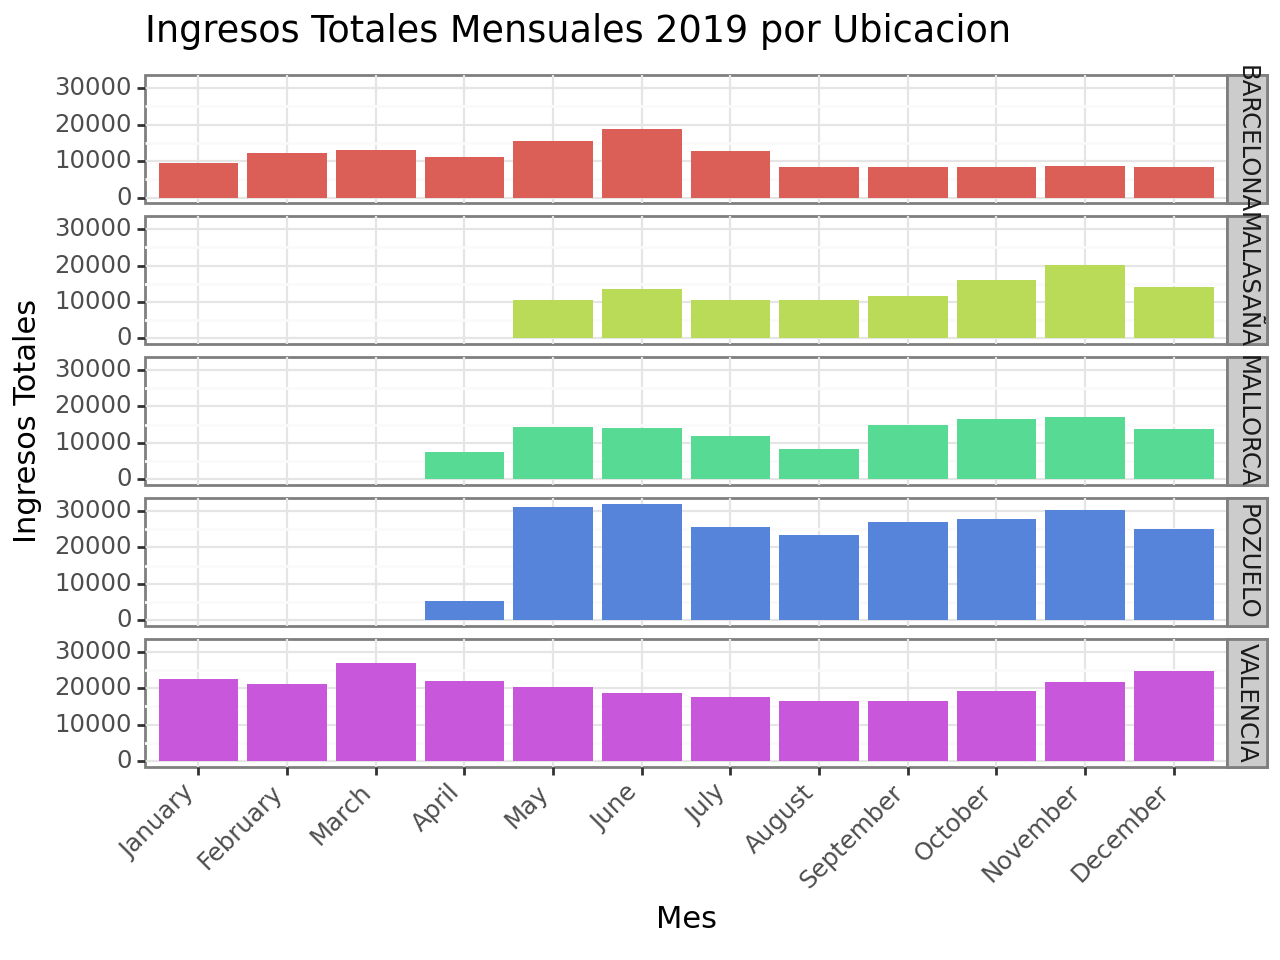

<Figure Size: (640 x 480)>

In [48]:
# Venta por meses 2019

ventas_mes_2019 = data.loc[data.año==2019].loc[:,["Local","Total","nombre_mes"]]\
    .groupby(["Local","nombre_mes"], as_index=False)\
        .agg(VentasTotales=("Total","sum"))

ventas_mes_2019["nombre_mes"] = pd.Categorical(ventas_mes_2019["nombre_mes"],\
                                          categories=months_order, ordered=True)

ggplot(aes("nombre_mes","VentasTotales",fill="Local"), ventas_mes_2019)\
    +geom_bar(stat="identity")\
    +facet_grid("Local ~ .")\
    +labs(title="Ingresos Totales Mensuales 2019 por Ubicacion",
         x="Mes",
         y="Ingresos Totales")\
    +theme_bw()\
    +theme(legend_position="none")\
    +theme(axis_text_x=element_text(angle=45, hjust=1))


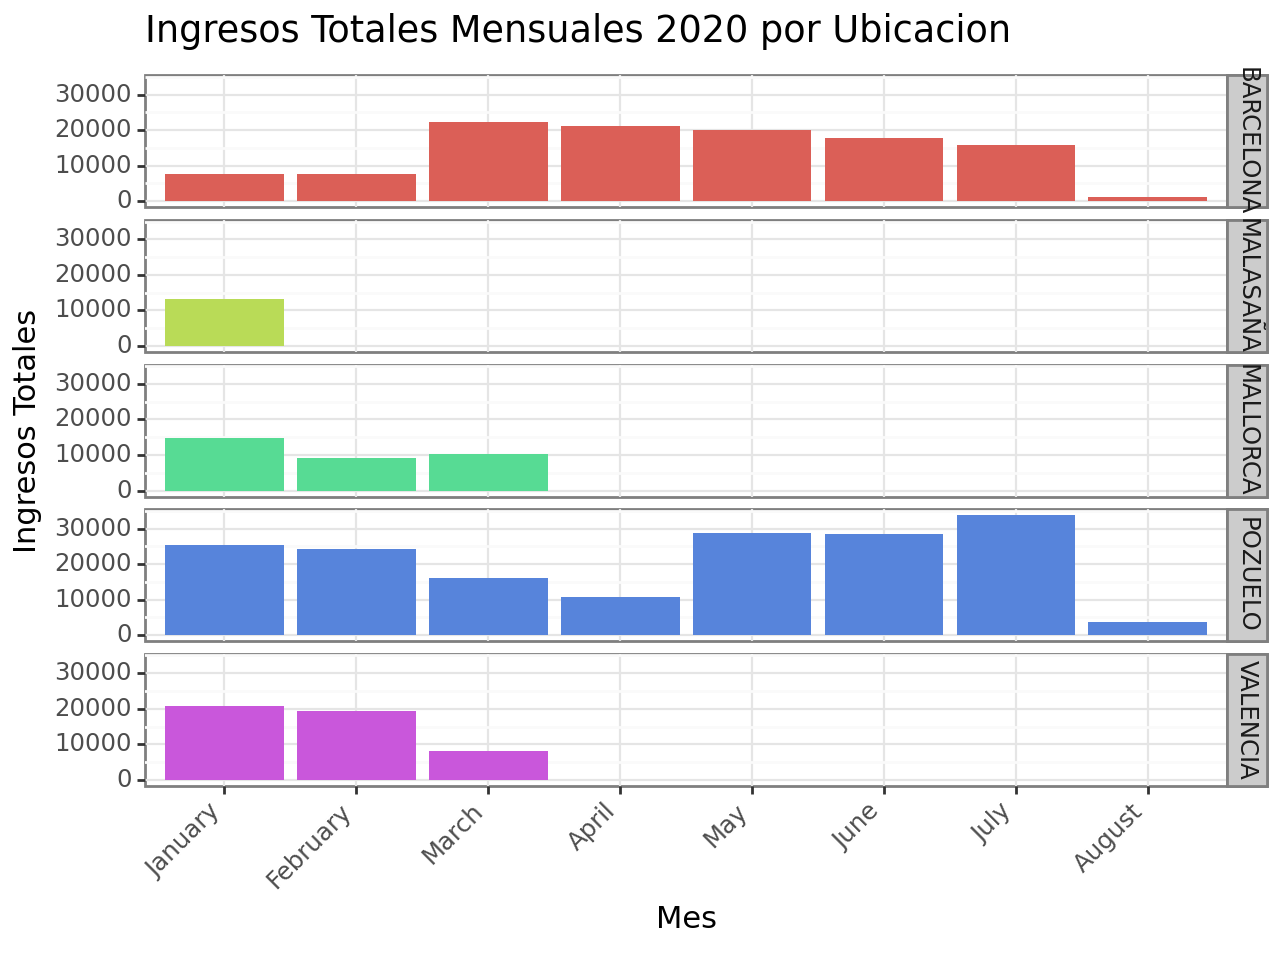

<Figure Size: (640 x 480)>

In [49]:
# Venta por meses 2020

ventas_mes_2020 = data.loc[data.año==2020].loc[:,["Local","Total","nombre_mes"]]\
    .groupby(["Local","nombre_mes"], as_index=False)\
        .agg(VentasTotales=("Total","sum"))

ventas_mes_2020["nombre_mes"] = pd.Categorical(ventas_mes_2020["nombre_mes"],\
                                          categories=months_order, ordered=True)

ggplot(aes("nombre_mes","VentasTotales",fill="Local"), ventas_mes_2020)\
    +geom_bar(stat="identity")\
    +facet_grid("Local ~ .")\
    +labs(title="Ingresos Totales Mensuales 2020 por Ubicacion",
         x="Mes",
         y="Ingresos Totales")\
    +theme_bw()\
    +theme(legend_position="none")\
    +theme(axis_text_x=element_text(angle=45, hjust=1))

Tras analizar los graficos podemos sacar varias conclusiones en cada localidad:


*   Barcelona: Vemos como en total las ventas son mayores en la primera mitad del año y luego disminuyen al termino del verano, presentando picos en primavera/verano. En el 2019 los ingresos se mantienen estables durante todo el año con pico en Junio y en 2020 presenta picos con la aparicion de la pandemia.
*   Malasaña: Carecemos de datos suficientes en el periodo febrero-abril, pero podemos observar estabilidad a lo largo del año con picos en junio y a finales de año. En el 2019 vemos como los meses mas fuertes son los de junio y noviembre y especialmente como el mayor volumem de ingresos son en el periodo de octubre-diciembre. en 2020 vemos como la pandemia afecto a esta localidad y no tuvo ingresos.
*   Mallorca: En esta localidad vemos como los ingresos se mantienen estables a lo largo del año con picos en verano y tambien en la segunda parte del año. En 2019 carecemos de datos hasta abril y vemos como hay picos de venta en los meses de verano (debido al turismo) asi como tambien en los meses de octubre-noviembre. En 2020 vemos como la tendencia del 2019 se mantuvo hasta que la pandemia del COVID 19 afecto totalmente sus ingresos.
*   Pozuelo: Aqui podemos observar como los ingresos se mantienen estable a lo largo del año pero con claros picos en los meses de verano. En el año 2019 no tenemos datos hasta abril y luego vemos como los ingresos son altos en el resto del año con picos en may-junio y noviembre. En el 2020 vemos como empieza el año fuerte y luego en los meses de marzo-abril hay una gran caida de ingresos debido al COVID pero a partir de mayo hasta fin de verano los ingresos vuelven a subir hasta la normalidad
*   Valencia: En Valencia vemos ingresos estables con picos a principio de año y final de año. En 2019 vemos picos en los meses de marzo y diciembre, siendo los peores meses los de agosto y septiembre. En 2020 vemos como la pandemia hizo que no se tuvieran ingresos luego de marzo.







Ahora procederemos a analizar los **ingresos por dia de la semana**

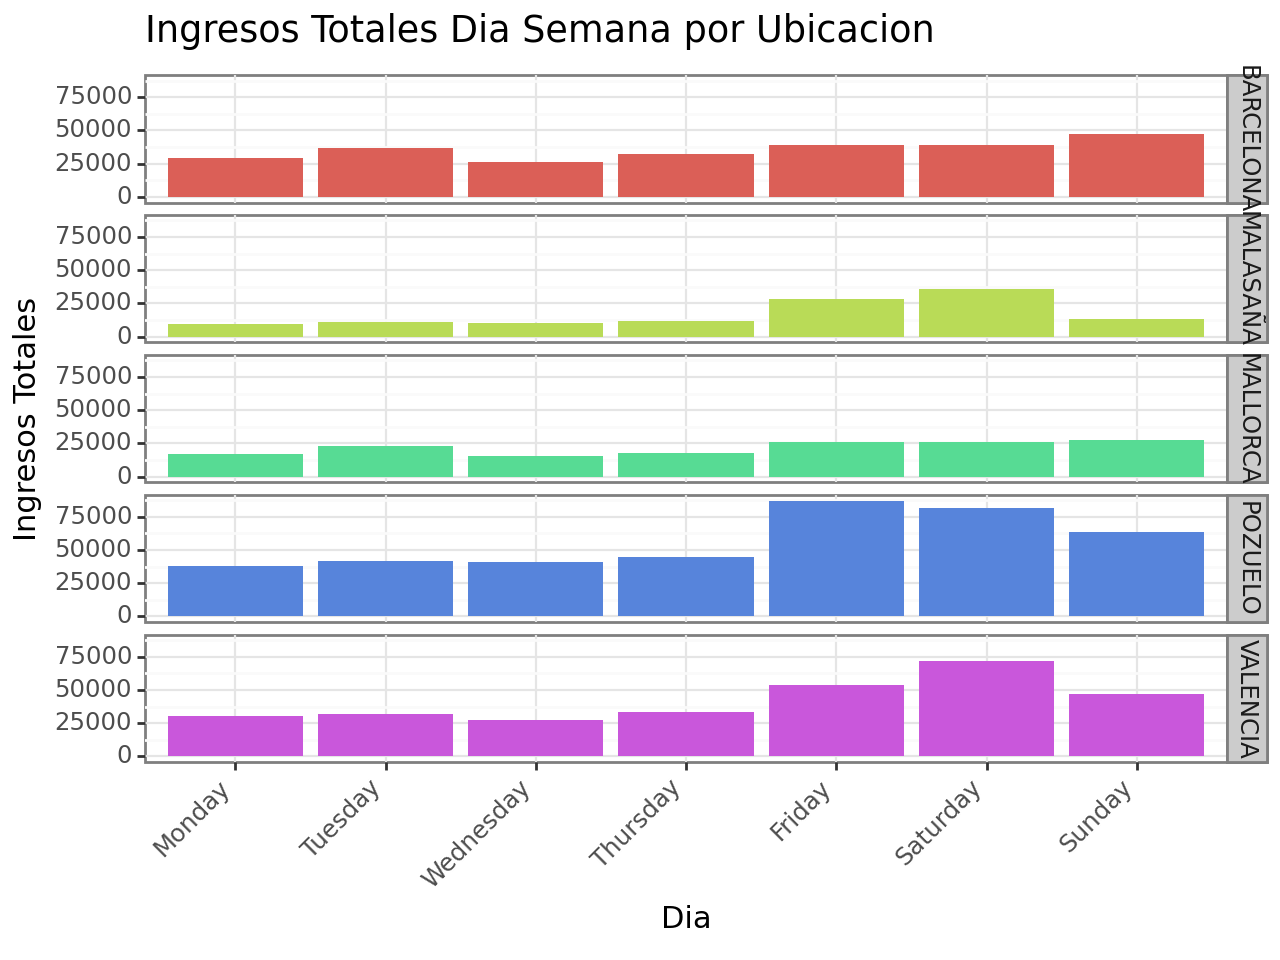

<Figure Size: (640 x 480)>

In [50]:
ventas_semana = data.loc[:,["Local","Total","nombre_dia"]]\
    .groupby(["Local","nombre_dia"], as_index=False)\
        .agg(VentasTotales=("Total","sum"))

week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",\
              "Saturday", "Sunday"]

ventas_semana["nombre_dia"] = pd.Categorical(ventas_semana["nombre_dia"],\
                                            categories=week_order, ordered=True)

ggplot(aes("nombre_dia","VentasTotales",fill="Local"), ventas_semana)\
    +geom_bar(stat="identity")\
    +facet_grid("Local ~ .")\
    +labs(title="Ingresos Totales Dia Semana por Ubicacion",
         x="Dia",
         y="Ingresos Totales")\
    +theme_bw()\
    +theme(legend_position="none")\
    +theme(axis_text_x=element_text(angle=45, hjust=1))

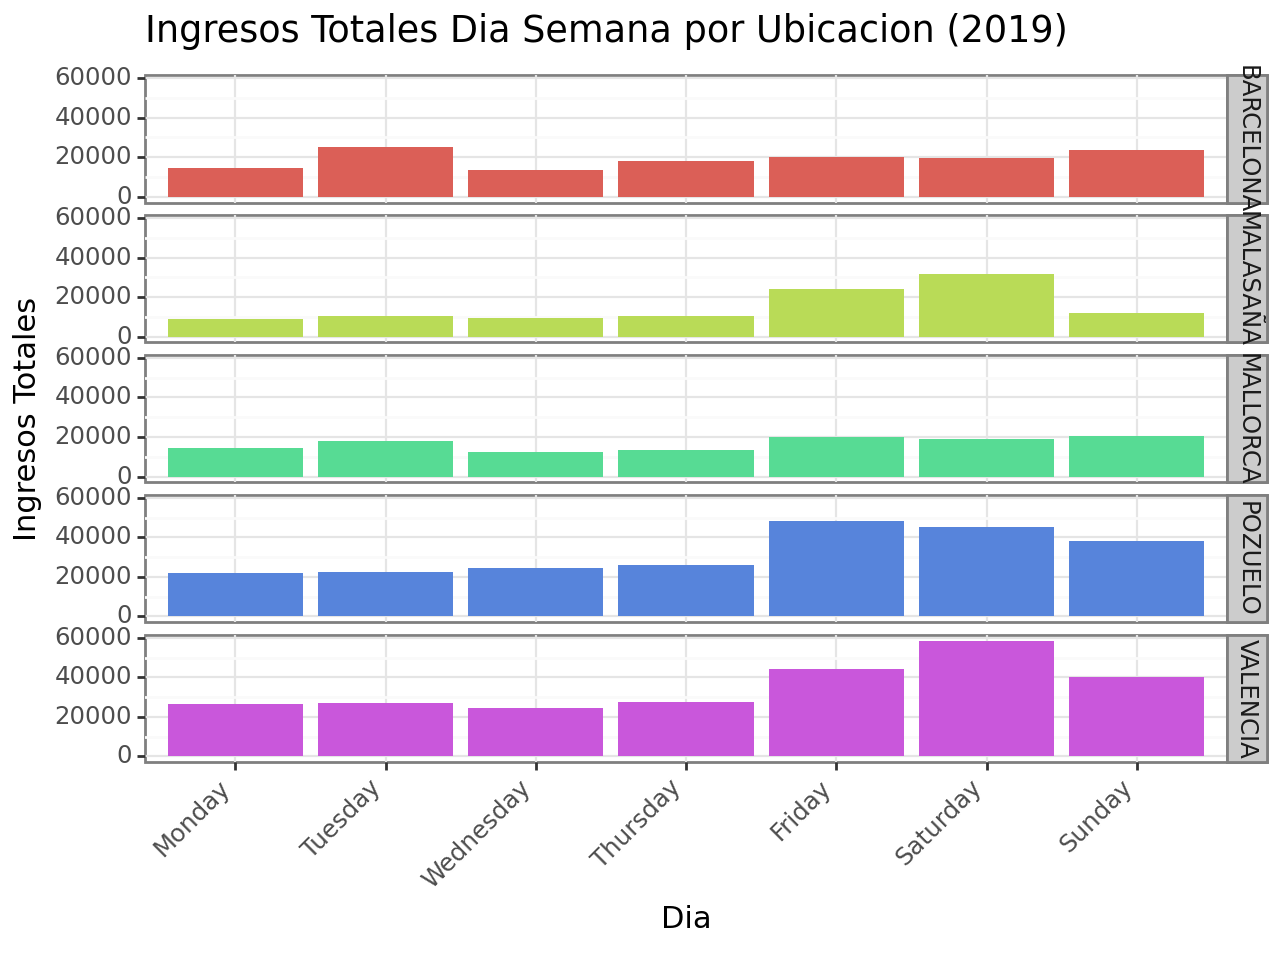

<Figure Size: (640 x 480)>

In [51]:
# Ingresos por dia de semana 2019

ventas_semana_2019 = data.loc[data.año==2019]\
    .loc[:,["Local","Total","nombre_dia"]]\
    .groupby(["Local","nombre_dia"], as_index=False)\
    .agg(VentasTotales=("Total","sum"))

ventas_semana_2019["nombre_dia"] = \
                pd.Categorical(ventas_semana_2019["nombre_dia"],\
                categories=week_order, ordered=True)

ggplot(aes("nombre_dia","VentasTotales",fill="Local"), ventas_semana_2019)\
    +geom_bar(stat="identity")\
    +facet_grid("Local ~ .")\
    +labs(title="Ingresos Totales Dia Semana por Ubicacion (2019)",
         x="Dia",
         y="Ingresos Totales")\
    +theme_bw()\
    +theme(legend_position="none")\
    +theme(axis_text_x=element_text(angle=45, hjust=1))

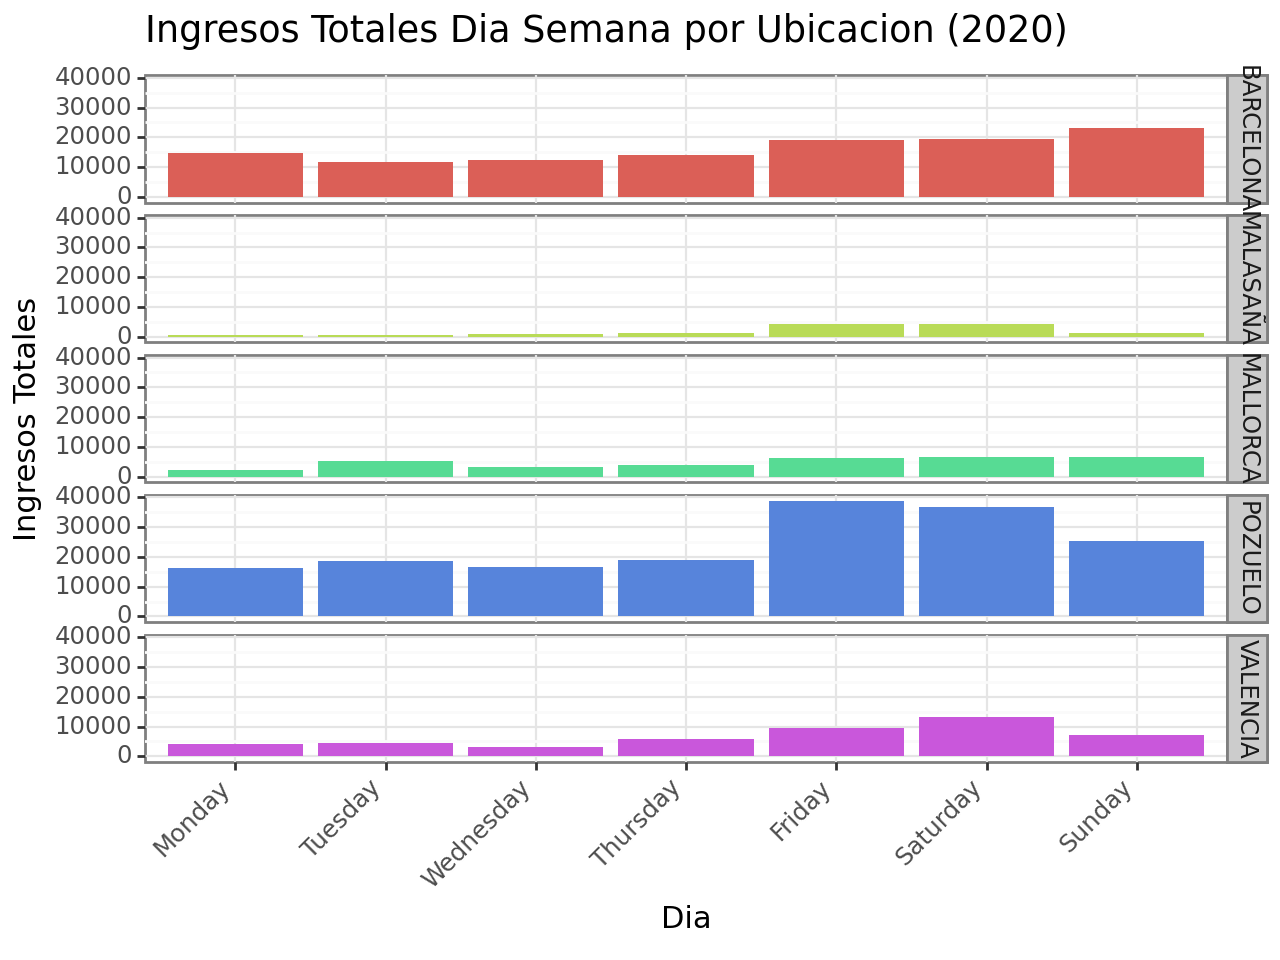

<Figure Size: (640 x 480)>

In [52]:
# Ingresos por dia de semana 2020

ventas_semana_2020 = data.loc[data.año==2020]\
    .loc[:,["Local","Total","nombre_dia"]]\
    .groupby(["Local","nombre_dia"], as_index=False)\
    .agg(VentasTotales=("Total","sum"))

ventas_semana_2020["nombre_dia"] = \
pd.Categorical(ventas_semana_2020["nombre_dia"], \
               categories=week_order, ordered=True)

ggplot(aes("nombre_dia","VentasTotales",fill="Local"), ventas_semana_2020)\
    +geom_bar(stat="identity")\
    +facet_grid("Local ~ .")\
    +labs(title="Ingresos Totales Dia Semana por Ubicacion (2020)",
         x="Dia",
         y="Ingresos Totales")\
    +theme_bw()\
    +theme(legend_position="none")\
    +theme(axis_text_x=element_text(angle=45, hjust=1))

Tras analizar los graficos podemos ver tendencias claras a lo largo de totas la localidades con alguna excepcion (en Barcelona).

Vemos que en numero de ingresos en considerablemente mayor los fines de semana en comparacion con los dias entre semana , con la excepcion en que en Barcelona tenemos un pico los martes que se puede comparar con los del fin de semana.

Ahora procederemos a analizar las **horas del dia en que se obtienen mas ingresos**

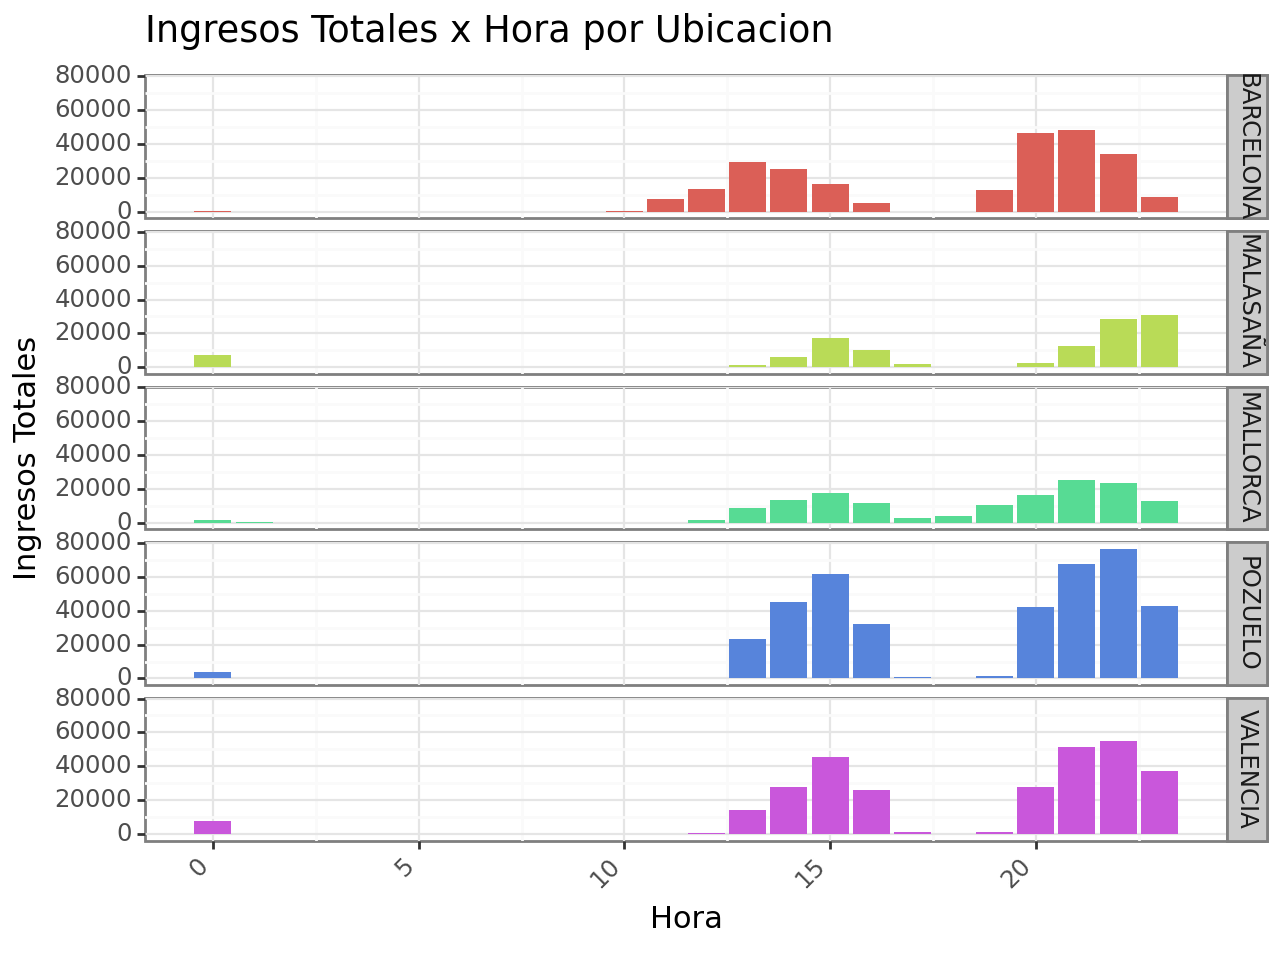

<Figure Size: (640 x 480)>

In [53]:
# Ingresos por hora del dia

ventas_hora = data.loc[:,["Local","Total","hora"]]\
    .groupby(["Local","hora"], as_index=False)\
        .agg(VentasTotales=("Total","sum"))


ggplot(aes("hora","VentasTotales",fill="Local"), ventas_hora)\
    +geom_bar(stat="identity")\
    +facet_grid("Local ~ .")\
    +labs(title="Ingresos Totales x Hora por Ubicacion",
         x="Hora",
         y="Ingresos Totales")\
    +theme_bw()\
    +theme(legend_position="none")\
    +theme(axis_text_x=element_text(angle=45, hjust=1))

Podemos observar claramente como en todas las localidades donde se obtienen mas ingresos son en las horas de almuerzo (13h-16h) y cena (20h-23h) con la excepcion de que en barcelona se ven ciertos picos en horas mas tempranas de la mañana a partir de las 10h.

Para finalizar, analizaremos si se reciben mas pedidos de media en dias festivos que no festivos asi determinaremos la importancia de dichos eventos.
(Para ello busque los festivos de los años 2019-2020 de españa y los de cada localidad y los importe al dataset)

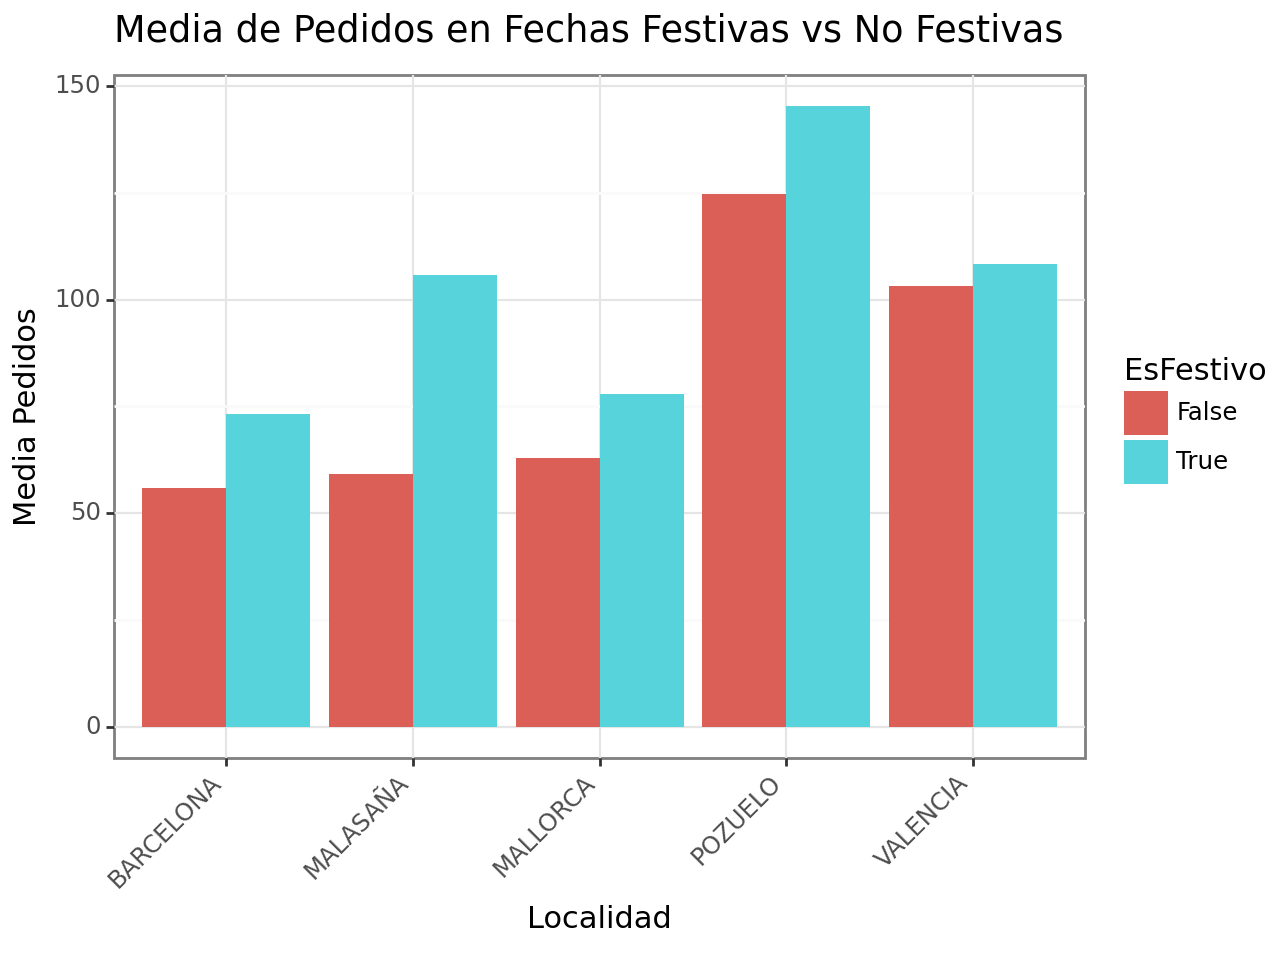

<Figure Size: (640 x 480)>

In [54]:
# Incidencia de festivos

festivos_nacionales = pd.to_datetime([
    '2019-01-01', '2019-01-06', '2019-04-19', '2019-05-01', '2019-08-15',
    '2019-10-12', '2019-11-01', '2019-12-06', '2019-12-25',
    '2020-01-01', '2020-01-06', '2020-04-10', '2020-05-01', '2020-08-15',
    '2020-10-12', '2020-11-01', '2020-12-06', '2020-12-25'
])

festivos_locales = {
    'BARCELONA': pd.to_datetime([
        '2019-04-21', '2019-06-10', '2019-06-24', '2019-09-24',
        '2020-04-13', '2020-06-01', '2020-06-24', '2020-09-24'
    ]),
    'VALENCIA': pd.to_datetime([
        '2019-01-22', '2019-03-19', '2019-04-22', '2019-06-24', '2019-10-09',
        '2020-01-22', '2020-03-19', '2020-04-13', '2020-06-24', '2020-10-09'
    ]),
    'POZUELO': pd.to_datetime([
        '2019-04-21', '2019-06-24',
        '2020-04-13', '2020-06-24'
    ]),
    'MALLORCA': pd.to_datetime([
        '2019-03-01', '2019-04-21', '2019-12-26',
        '2020-03-01', '2020-04-13', '2020-12-26'
    ]),
    'MALASAÑA': pd.to_datetime([
        '2019-05-15', '2019-11-09',
        '2020-05-15', '2020-11-09'
    ])
}

data["Fecha"] = pd.to_datetime(data["Fecha"])

# Ponemos como index la fecha para hacer las comparaciones mas faciles
data.set_index("Fecha", inplace=True)

# Vamos comparando fechas
def es_festivo_local(row):
    if row["Local"] in festivos_locales:
        return row.name in festivos_locales[row["Local"]]
    return False

data["EsFestivoNacional"] = data.index.isin(festivos_nacionales)
data["EsFestivoLocal"] = data.apply(es_festivo_local, axis=1)

data["EsFestivo"] = data["EsFestivoNacional"] | data["EsFestivoLocal"]

pedidos_por_dia = data.groupby([data.index.date, "Local", "EsFestivo"])\
        .size().reset_index(name="NumPedidos")

media_pedidos_festivos = pedidos_por_dia.groupby(["Local", "EsFestivo"])\
 ["NumPedidos"].mean().reset_index()

ggplot(aes("Local","NumPedidos",fill="EsFestivo"), media_pedidos_festivos)\
    +geom_bar(stat="identity",  position="dodge")\
    +labs(title="Media de Pedidos en Fechas Festivas vs No Festivas",
         x="Localidad",
         y="Media Pedidos")\
    +theme_bw()\
    +theme(axis_text_x=element_text(angle=45, hjust=1))

Aqui podemos ver claramente como la media de pedidos es mayor en dias festivos , lo que supone un aumento de ingresos substancial en dichos dias.

## 2. Análisis Geográfico:
¿Cómo se comparan las ventas totales y promedios entre las cinco ubicaciones?


Para contestar a esta pregunta analizaremos el numero total de ventas (ingresos), ventas promedio (media de precio) y numero de pedidos totales en cada localdiad

In [55]:
# Creamos ventas agrupando por Local y calculando los valores mencionados
#anteriormente

ventas = data.groupby("Local", as_index=False)\
            .agg(TotalVentas=("Total","sum"),MediaVentas=("Total","mean"),\
                 NumVentas=("Local","size"))

Grafico de Total Ventas

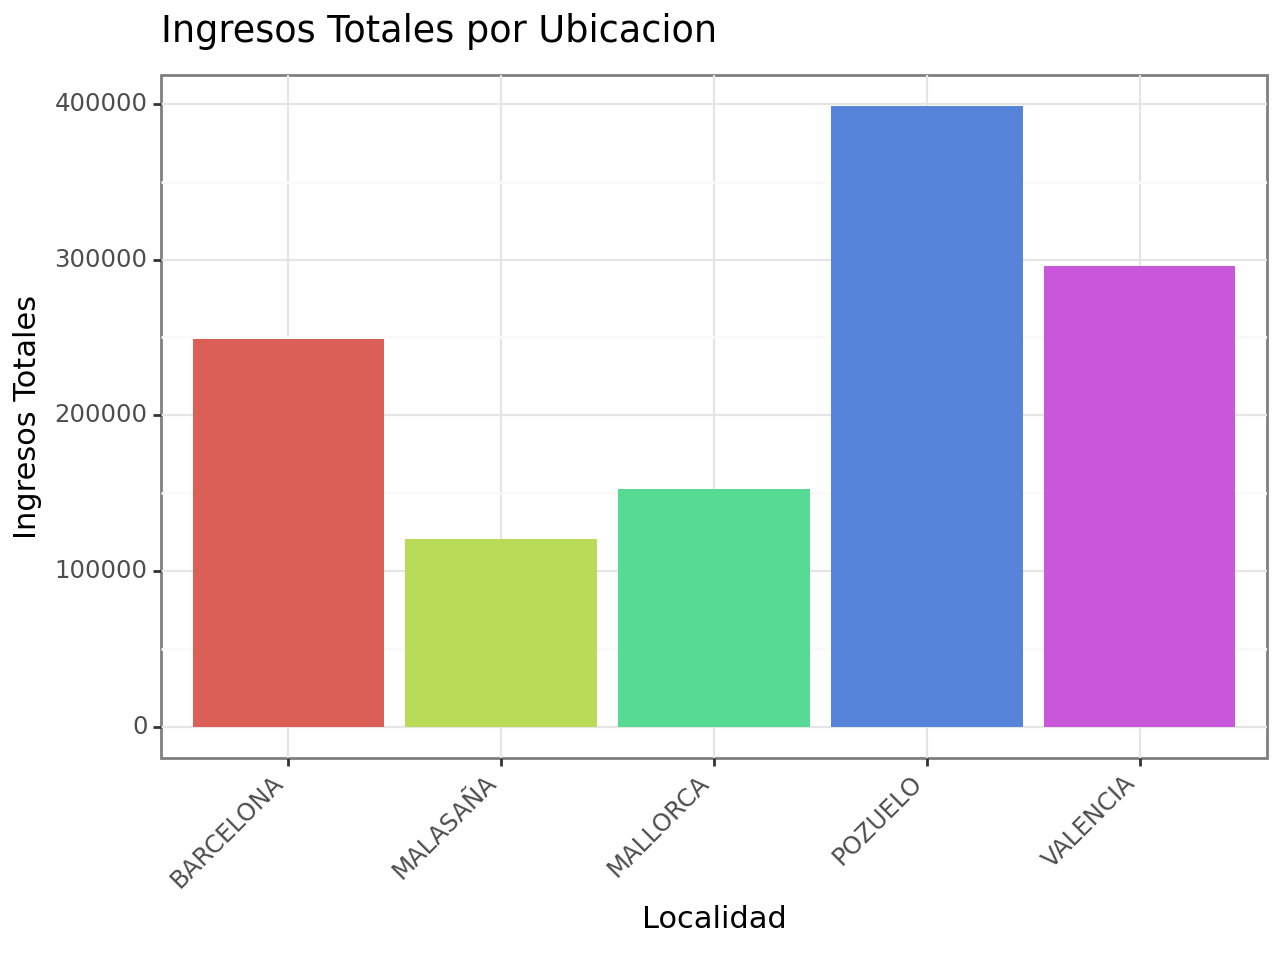

<Figure Size: (640 x 480)>

In [56]:
ggplot(aes("Local","TotalVentas",fill="Local"), ventas)\
    +geom_bar(stat="identity")\
    +labs(title="Ingresos Totales por Ubicacion",
         x="Localidad",
         y="Ingresos Totales")\
    +theme_bw()\
    +theme(legend_position="none")\
    +theme(axis_text_x=element_text(angle=45, hjust=1))

Grafico de Precio medio de ventas

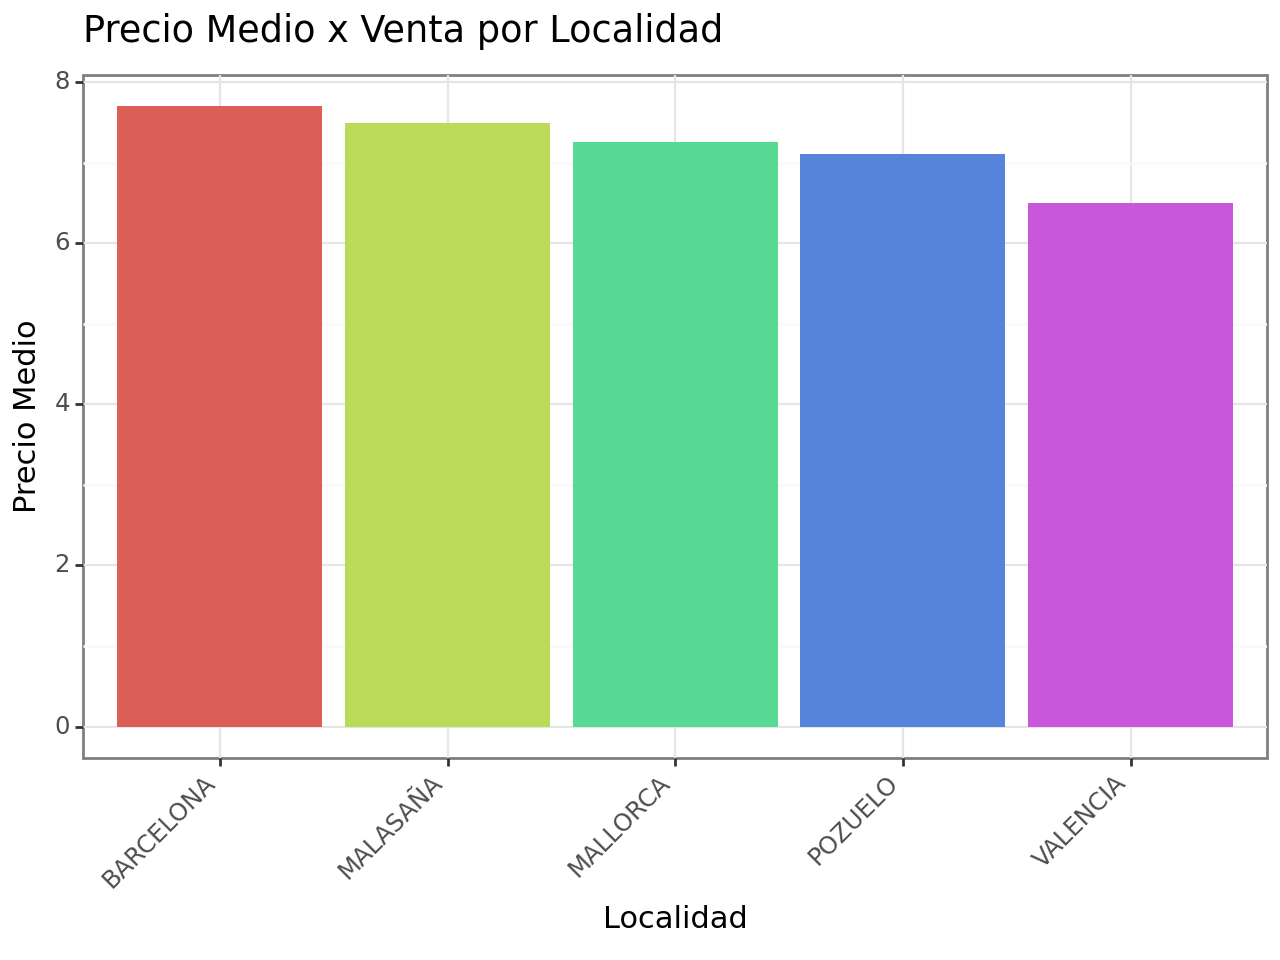

<Figure Size: (640 x 480)>

In [57]:
ggplot(aes("Local","MediaVentas",fill="Local"), ventas)\
    +geom_bar(stat="identity")\
    +labs(title="Precio Medio x Venta por Localidad",
         x="Localidad",
         y="Precio Medio")\
    +theme_bw()\
    +theme(legend_position="none")\
    +theme(axis_text_x=element_text(angle=45, hjust=1))

Grafico de Numero de ventas

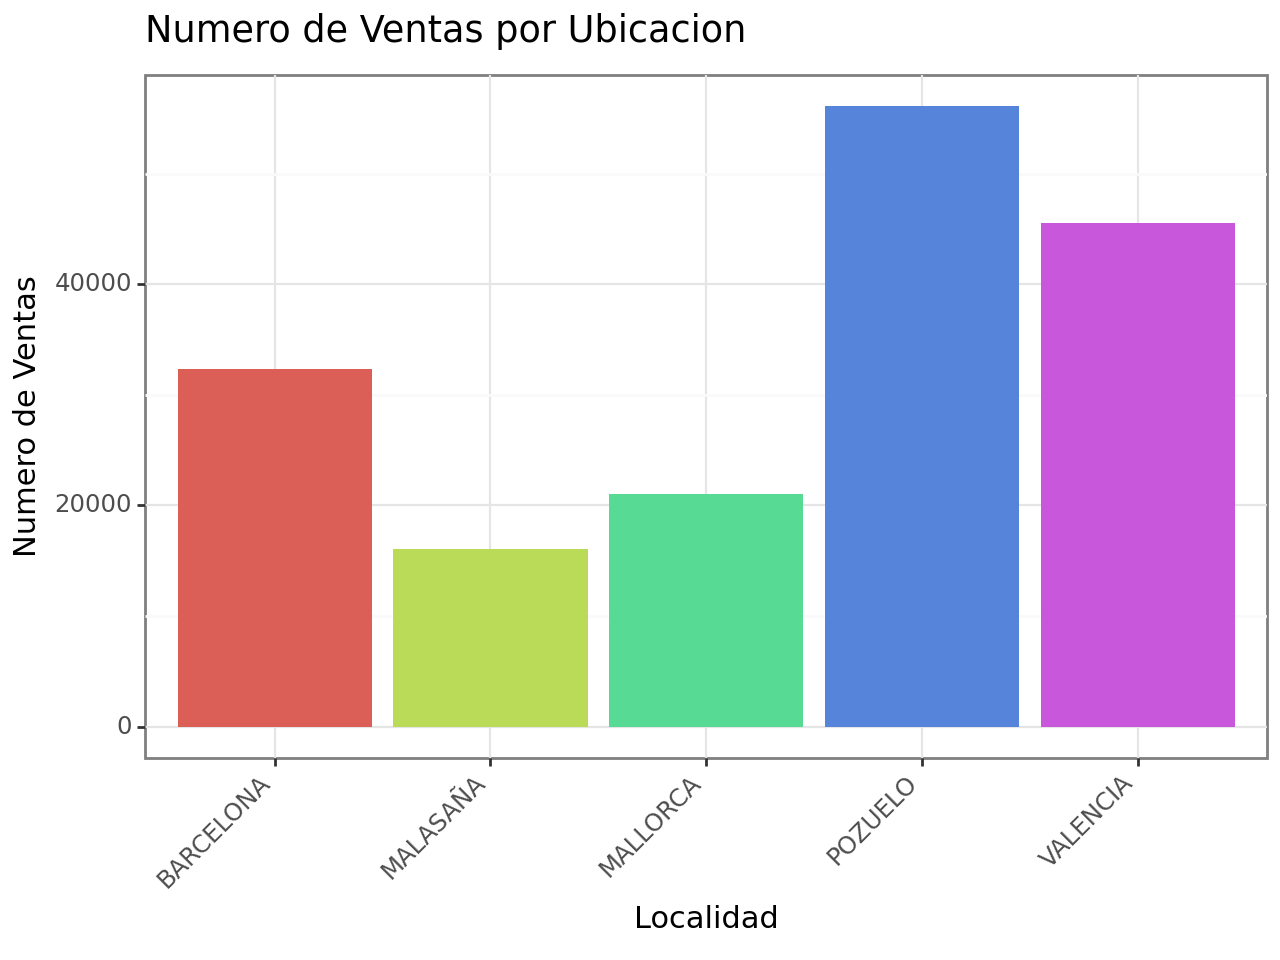

<Figure Size: (640 x 480)>

In [58]:
ggplot(aes("Local","NumVentas",fill="Local"), ventas)\
    +geom_bar(stat="identity")\
    +labs(title="Numero de Ventas por Ubicacion",
         x="Localidad",
         y="Numero de Ventas")\
    +theme_bw()\
    +theme(legend_position="none")\
    +theme(axis_text_x=element_text(angle=45, hjust=1))

Ahora para entender todo mejor, haremos una correlacion entre las 3 graficas

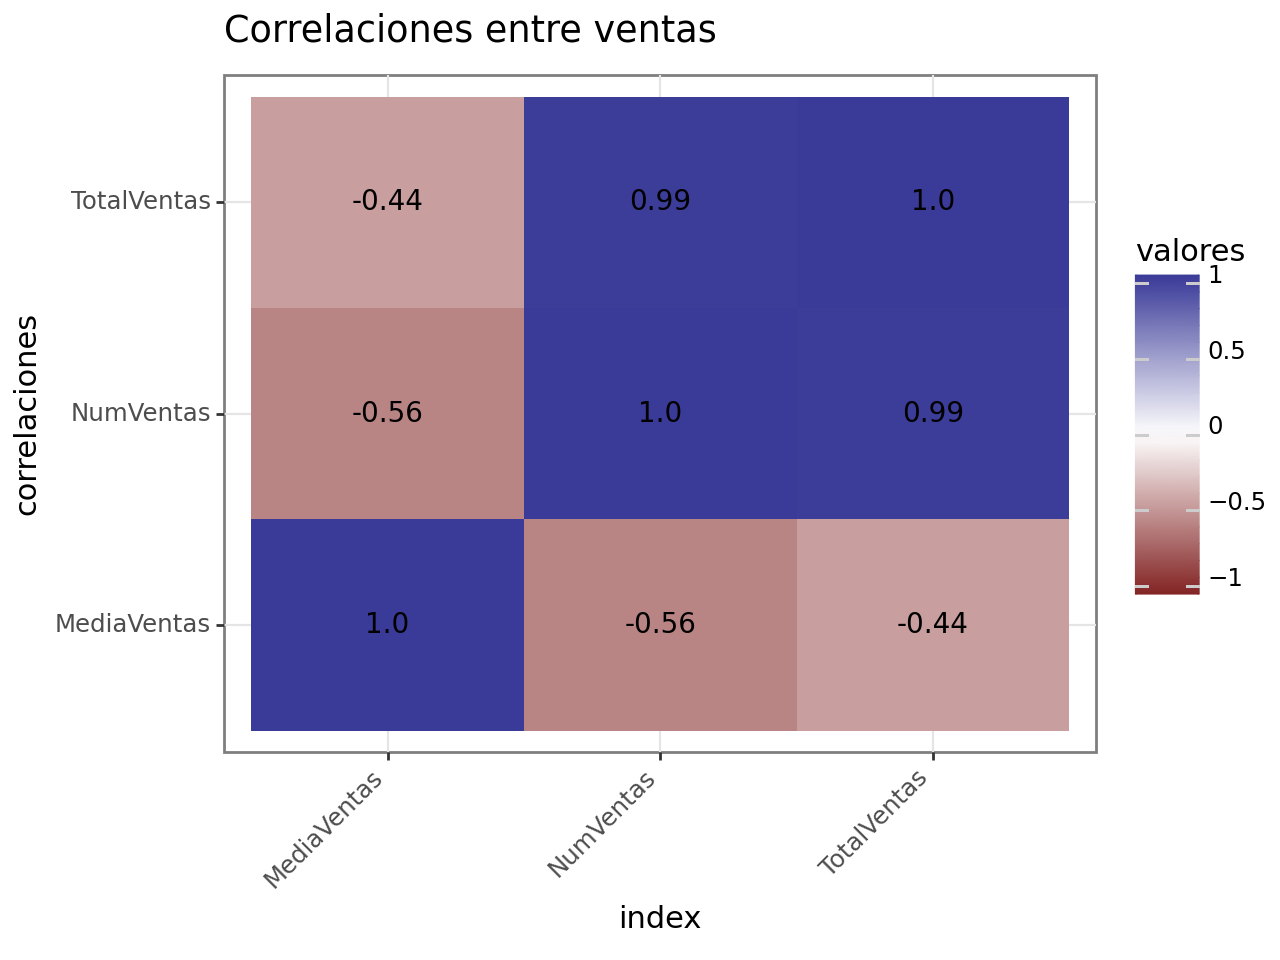

<Figure Size: (640 x 480)>

In [59]:
corr = ventas[["TotalVentas", "MediaVentas", "NumVentas"]].corr().reset_index()

corr = pd.melt(corr, id_vars=["index"],var_name="correlaciones",\
                 value_name="valores")

corr.valores=corr.valores.round(2)

ggplot(aes("index","correlaciones",fill="valores"), corr)\
    +geom_tile()\
    +ggtitle("Correlaciones entre ventas")\
    +theme_bw()\
    +scale_fill_gradient2(limits=[-1,1])\
    +geom_text(aes(label="valores"),size=10)\
    +theme(axis_text_x=element_text(angle=45, hjust=1))

Tras ver todos estos graficos podemos ver claramente cuales localidades son las que mas y menos ingresos generan, en este caso la que mas genera es la de Pozuelo y la que menos la de Malasaña.

Por otra parte vemos que el precio medio es batante similar entre localidades, aunque la que mayor precio medio tiene es la de Barcelona y la que menos la de Valencia.

Para enteder mejor todo, analizando el grafico de correlaciones podemos decir que:

*   Existe una relacion positiva muy fuerte entre el total de ventas y el numero de ventas, lo que significa que las localidades con mas pedidos tienden a generar mas ingresos totales
*   La correlacion negativa moderada entre la media de ventas por pedido y el total/numero de ventas nos dice que en algunas localidades un mayor numero de pedidos puede estar asociado con una disminucion en el valor promedio de cada venta. Esto podría indicar promociones, descuentos o una mayor cantidad de ventas de artículos de menor precio en dichas localidades





---


¿Cuál es la distribución de clientes y cuáles son los productos más populares en cada ubicación?

Para ver la distribucion de clientes veremos cuantos clientes unicos hay por localidad. Para ello volvemos a meter la variable de CIF y no la de cliente, ya que considero que con el CIF tendremos los clientes unicos. Tambien porque he observado que muchas veces escriben mal el nombre del cliente por lo que el mismo cliente sale diferente varias veces.

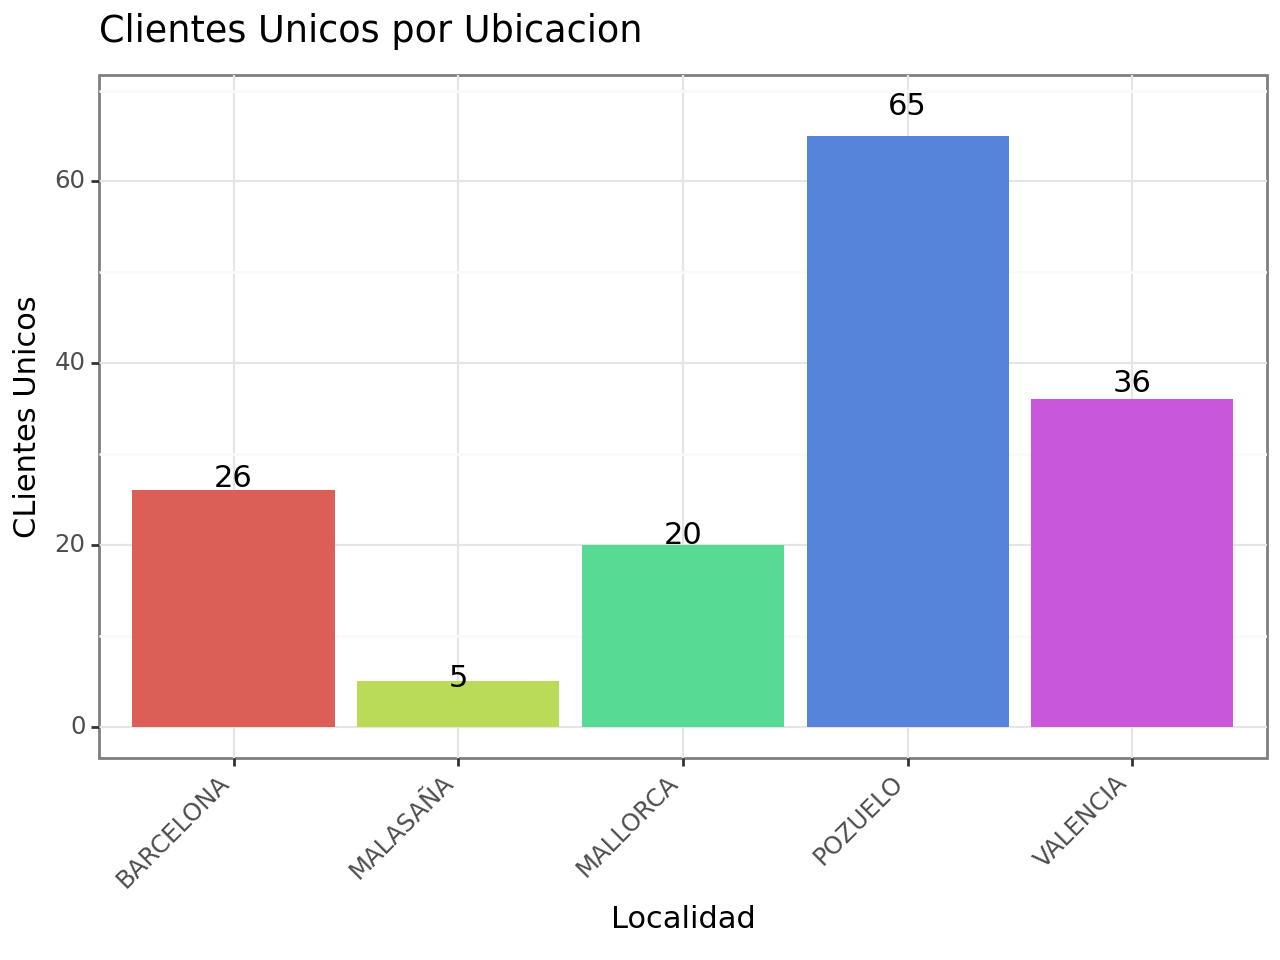

<Figure Size: (640 x 480)>

In [79]:
data2 = pd.concat([barcelona,malasaña,mallorca,valencia,pozuelo],axis=0,\
                 ignore_index=True)

data2 = data2.rename(columns=lambda x: x.replace(' ', ''))
data2.drop(["Cliente","CuentaContable","Ciudad","Provincia",\
          "Calle","CódigoPostal","GrupoMayor","Cód.Promoción","Cód.Descuento"],\
           axis=1, inplace=True)

data2["Local"] = data2.Local.str.replace(r" \(\✔\)", "", regex=True)
data2 = data2.sort_values("Total", ascending=False)

data2.drop(data2.index[:5], inplace=True)

clientes_unicos = data2.groupby("Local", as_index=False)\
          .agg(ClientesUnicos=("CIF","nunique"))

ggplot(aes("Local","ClientesUnicos",fill="Local"), clientes_unicos)\
    +geom_bar(stat="identity")\
    +labs(title="Clientes Unicos por Ubicacion",
         x="Localidad",
         y="CLientes Unicos")\
    +theme_bw()\
    +theme(legend_position="none")\
    +geom_text(aes(label="ClientesUnicos"),position=position_stack(vjust=1.05))\
    +theme(axis_text_x=element_text(angle=45, hjust=1))

Aqui podemos observar como la mayor cantidad de cliientes estan en Pozuelo, Barcelona y Valencia, mientras la que menos tiene es Malasaña

Ahora para poder ver los productos mas vendidos por localidad haremos lo siguiente:

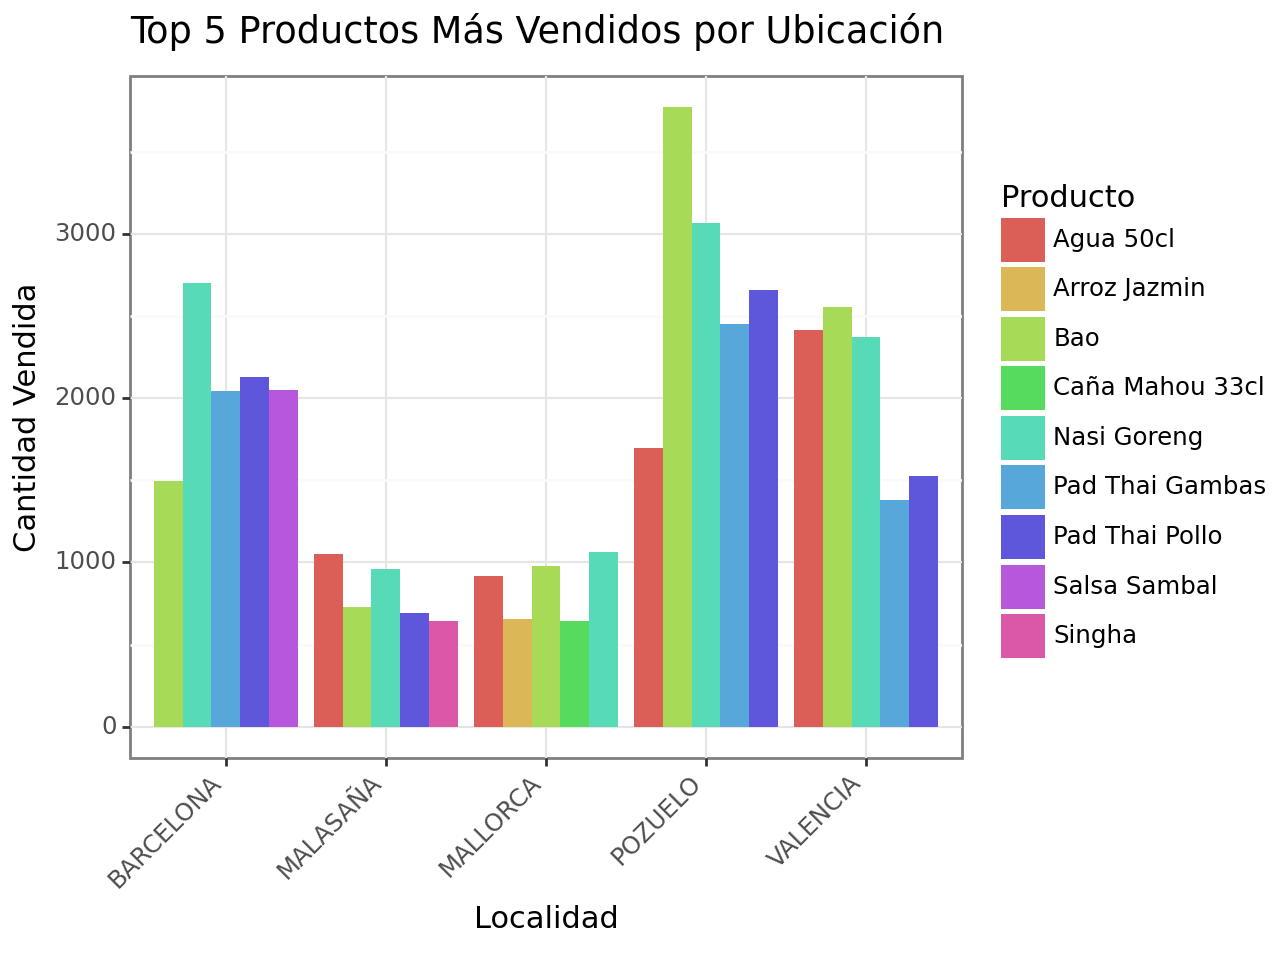

<Figure Size: (640 x 480)>

In [61]:
productos_populares = data.groupby(["Local", "Producto"], as_index=False)\
    .agg(CantidadVendida=("Producto", "size"))

productos_mas_vendidos = productos_populares\
          .sort_values(["Local","CantidadVendida"],ascending=False)\
          .groupby("Local", as_index=False).head(5)

ggplot(aes("Local","CantidadVendida",fill="Producto"),productos_mas_vendidos)\
  +geom_bar(stat='identity', position='dodge')\
  +labs(title="Top 5 Productos Más Vendidos por Ubicación",\
        x="Localidad",\
        y="Cantidad Vendida")\
  +theme_bw()\
  +theme(axis_text_x=element_text(angle=45, hjust=1))

Podemos ver que producto es el mas vendido en cada localidad, en este caso serian

1.   Bao en Pozuelo
2.   Nasi Goreng en Barcelona
3.   Bao en Valencia
4.   Nasi Goreng en Mallorca
5.   Agua 50cl en Malasaña


## 3. Análisis de Descuentos
¿Cómo afectan los descuentos al aumento de las ventas en cada ubicación?
¿Cuáles son los tipos de descuentos más utilizados y cuál es su impacto en los ingresos?

Para responder esta pregunta analicemos primero que porcentaje de ventas han tenido descuento para poder ver si tenemos un porcentaje lo suficientemente mayor para realizar el analisis propuesto

In [62]:
# Creamos una columna para indicar si hay descuento

data["HayDescuento"] = (data["Dto.%"] > 0) | (data["Dto.€"] > 0)

# Calculamos el numero total de ventas con y sin descuentos

ventas_con_descuento = data.HayDescuento.sum()
ventas_sin_descuento = len(data) - ventas_con_descuento

print(f"Numero total de ventas con descuento: {ventas_con_descuento}")
print(f"Numero total de ventas sin descuento: {ventas_sin_descuento}")

porcentaje = (ventas_con_descuento / ventas_sin_descuento ) * 100
porcentaje = porcentaje.round(2)

print(f"Porcentaje de ventas con descuento: {porcentaje} %")

Numero total de ventas con descuento: 2400
Numero total de ventas sin descuento: 168686
Porcentaje de ventas con descuento: 1.42 %


Como podemos observar, el porcentaje de ventas con descuentos al ser tan pequeña 1.48% no nos daria una representacion verdadera del impacto de los descuentos por lo que considero que no se puede realizar este analisis

## 4. Comparación de Precios:
¿Existe variación significativa en los precios de productos similares entre las ubicaciones?
¿Qué diferencias estratégicas en precios pueden identificarse entre Barcelona, Valencia, Pozuelo, Mallorca y Malasaña?

Para responder esta pregunta , creamos un dataset con los productos filtrados por localidad, que su "TipoLinea" sea Producto y para mayor facilidad seleccionaremos los 10 productos mas vendidos en general y compararemos su precio.

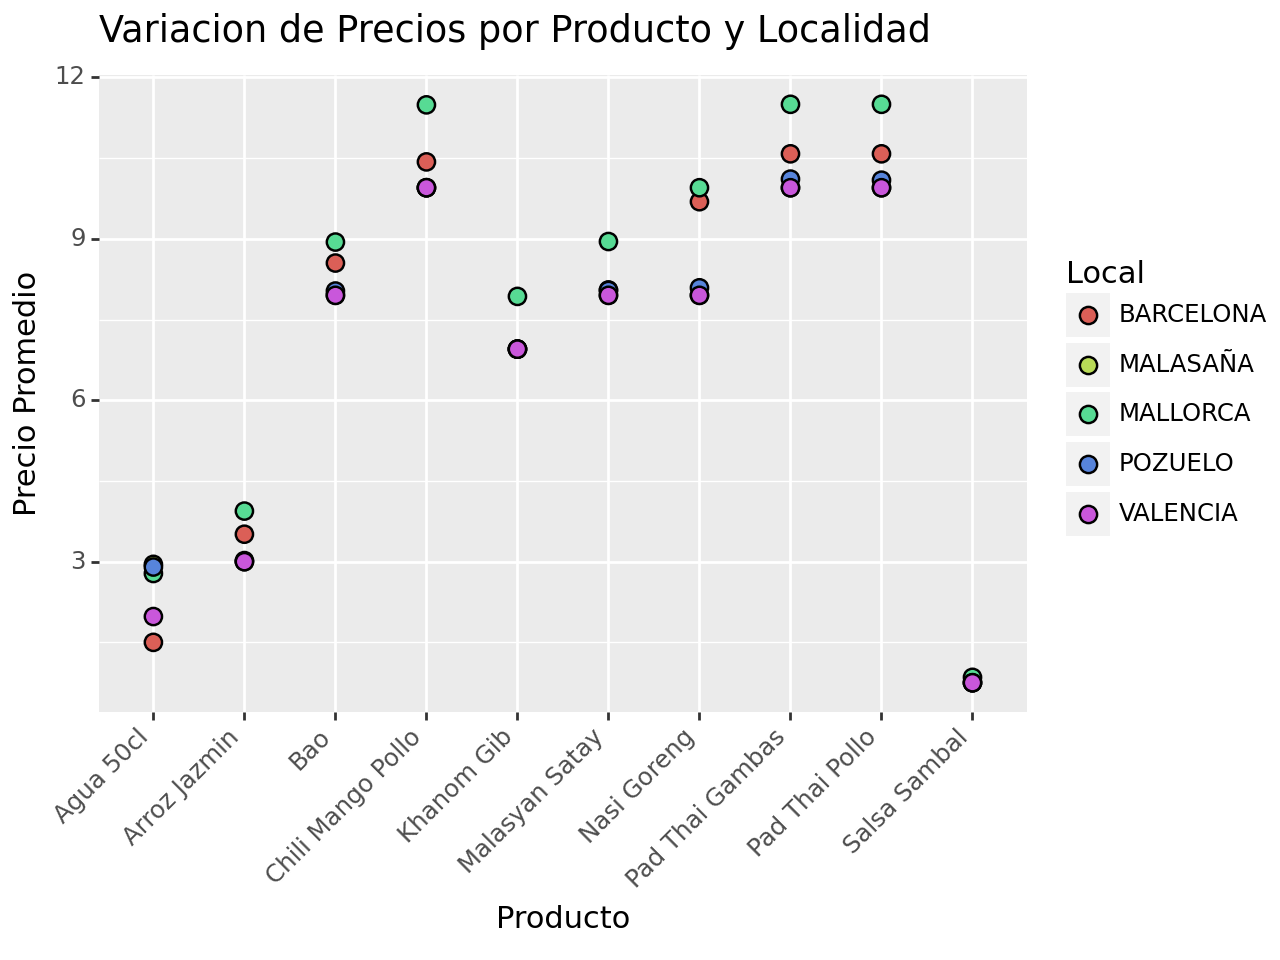

<Figure Size: (640 x 480)>

In [63]:
# Creamos el data set con el filtrado

productos = data.loc[data.TipoLínea=="Producto"]\
                .loc[:,["Local","Producto","Precio"]]

# Hacemos una lista con el top 10 de productos

top_productos = (productos["Producto"].value_counts()\
                .head(10).index.tolist())

pruducto_grafico = productos[productos["Producto"].isin(top_productos)]

# Sacamos el precio promedio de cada producto ya que hay diferentes precio para
# una misma localidad

pruducto_grafico = pruducto_grafico\
    .groupby(["Local", "Producto"], as_index=False)\
    .agg(PrecioPromedio=("Precio", "mean"))

pruducto_grafico.PrecioPromedio = pruducto_grafico.PrecioPromedio.round(2)

# Graficamos

ggplot(aes("Producto","PrecioPromedio", fill="Local"), pruducto_grafico)\
        + geom_point(size=3)\
        + theme(axis_text_x=element_text(rotation=45, hjust=1))\
        + labs(title="Variacion de Precios por Producto y Localidad",
               x="Producto",
               y="Precio Promedio",
               fill="Local")

Podemos observar como el precio promedio de los productos es mas o menos similar aunque se nota como en Mallorca suele ser mas caro y en Valencia el mas barato. No considero que haya una variacion significativa entre precio.

Para seguir respondiendo mejor sacaremos ahora el precio promedio total por localidad

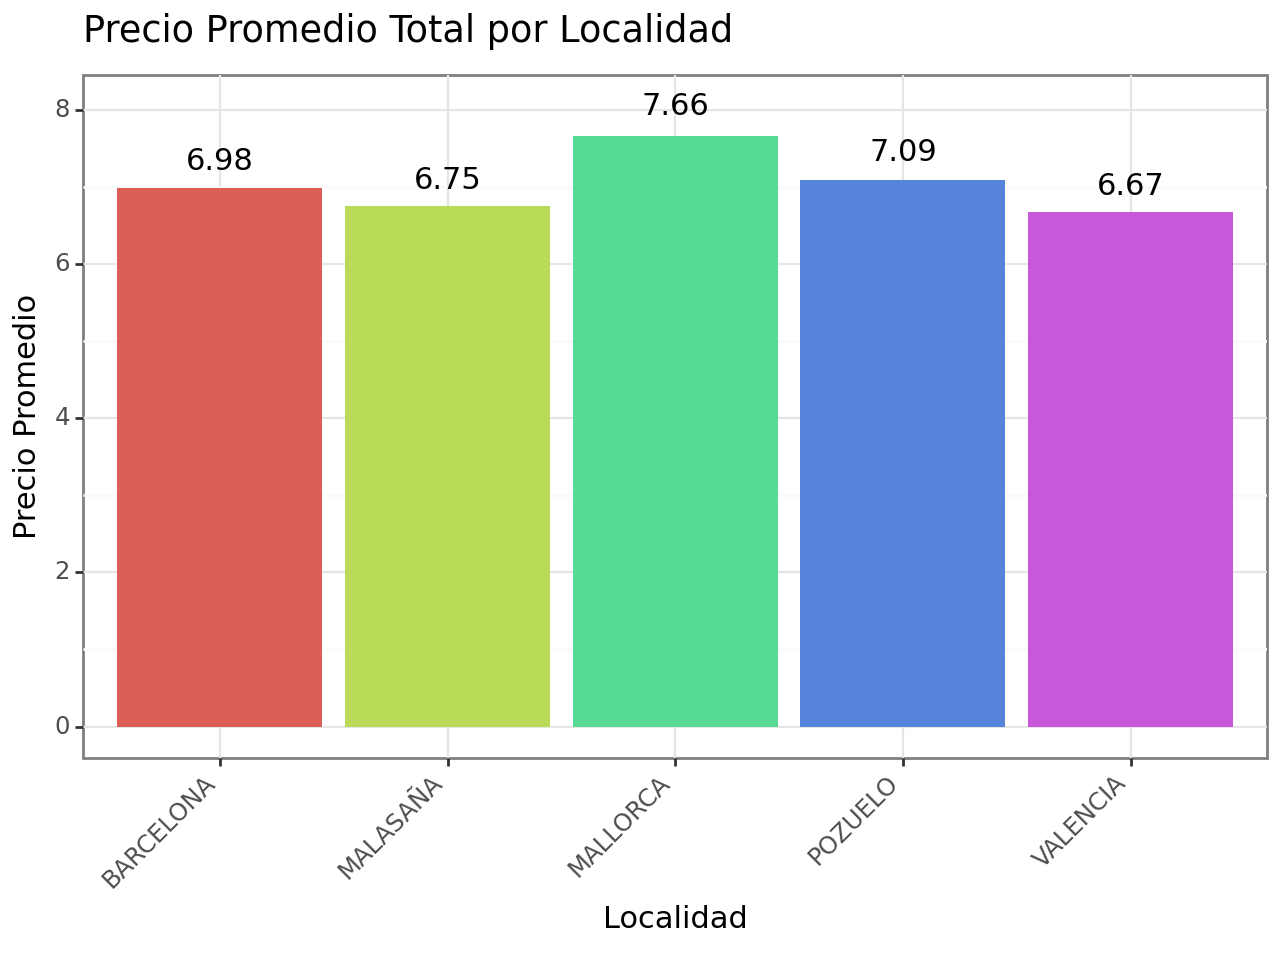

<Figure Size: (640 x 480)>

In [64]:
productos_promedio = productos.groupby("Local", as_index=False).agg(
    PrecioPromedio=("Precio", "mean")
)

productos_promedio.PrecioPromedio = productos_promedio.PrecioPromedio.round(2)

ggplot(aes("Local","PrecioPromedio",fill="Local"), productos_promedio)\
    +geom_bar(stat="identity")\
    +labs(title="Precio Promedio Total por Localidad",
         x="Localidad",
         y="Precio Promedio")\
    +theme_bw()\
    +theme(legend_position="none")\
    +geom_text(aes(label="PrecioPromedio"),position=position_stack(vjust=1.05))\
    +theme(axis_text_x=element_text(angle=45, hjust=1))

Aqui podemos confirmar un poco mas de lo que hablaba antes. Se puede ver como en Mallorca el precio es mas alto debido probablemente al ser un destino turistico. Luego tenemos a Pozuelo que es una de las zonas mas caras de Madrid, vemos como el precio tambien es elevado acorde a la zona y ciudad en que esta, algo similar pasa con Barcelona que vemos como el precio es muy parecido al de Pozuelo ya que estan en ciudades grandes. Seguidamente tenemos a Malasaña que es otro barrio de Madrid pero con menos poder adquisitivo que Pozuelo, por eso vemos con su precio promedio es menor a pesar de estar en la misma ciudad. Por ultimo tenemos a Valencia, que es una ciudad donde el coste de vida no es muy elevado en comparacion a las demas localidades y se ve reflejado en el precio promedio.

## 5. Productos Más Vendidos:
¿Cuáles son los productos más vendidos en cada ubicación?
¿Cómo varía la popularidad de los productos a lo largo de diferentes meses y días en cada ubicación?

Volvemos a tomar el grafico realizado en el apartdo 2

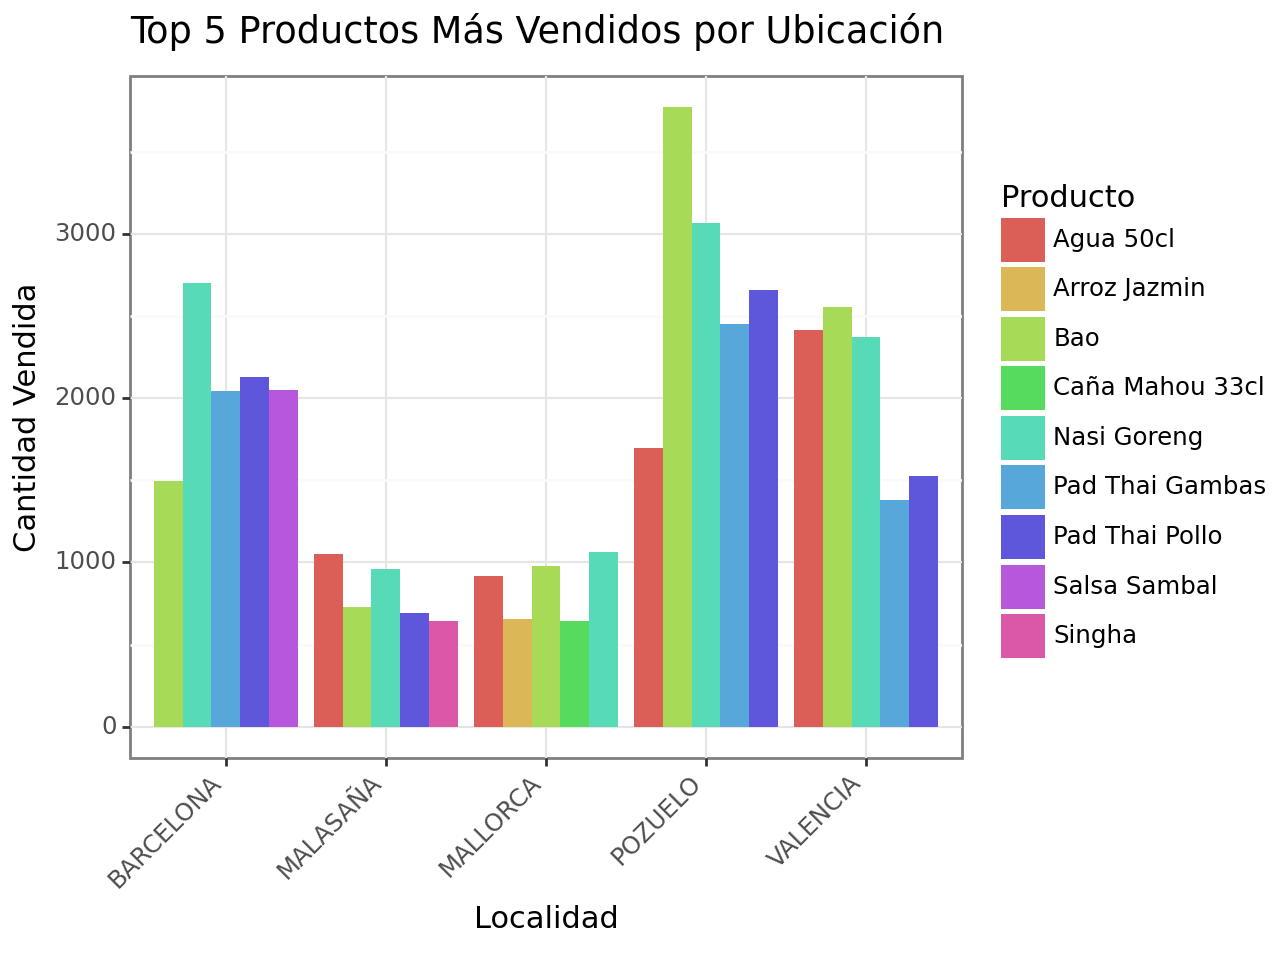

<Figure Size: (640 x 480)>

In [65]:
productos_populares = data.groupby(["Local", "Producto"], as_index=False)\
    .agg(CantidadVendida=("Producto", "size"))

productos_mas_vendidos = productos_populares\
          .sort_values(["Local","CantidadVendida"],ascending=False)\
          .groupby("Local", as_index=False).head(5)

ggplot(aes("Local","CantidadVendida",fill="Producto"),productos_mas_vendidos)\
  +geom_bar(stat='identity', position='dodge')\
  +labs(title="Top 5 Productos Más Vendidos por Ubicación",\
        x="Localidad",\
        y="Cantidad Vendida")\
  +theme_bw()\
  +theme(axis_text_x=element_text(angle=45, hjust=1))

Ahora que podemos observar los productos que mas se venden en cada localidad, pasaremos a analizar el comportamiento mensual y diario.

Empezaremos primero con el mensual:

<ipython-input-66-61f9d7d703eb>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


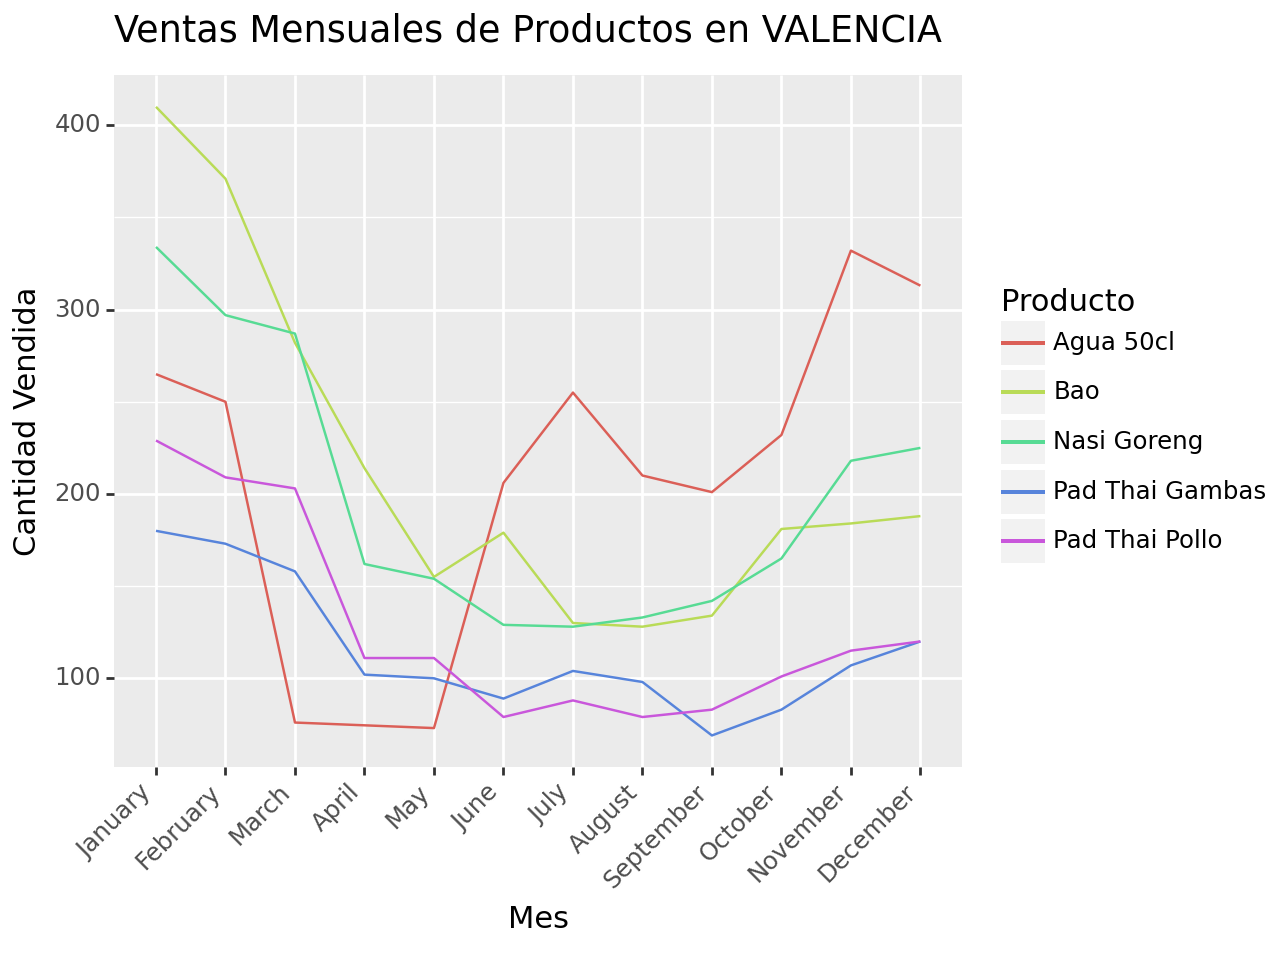

<ipython-input-66-61f9d7d703eb>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


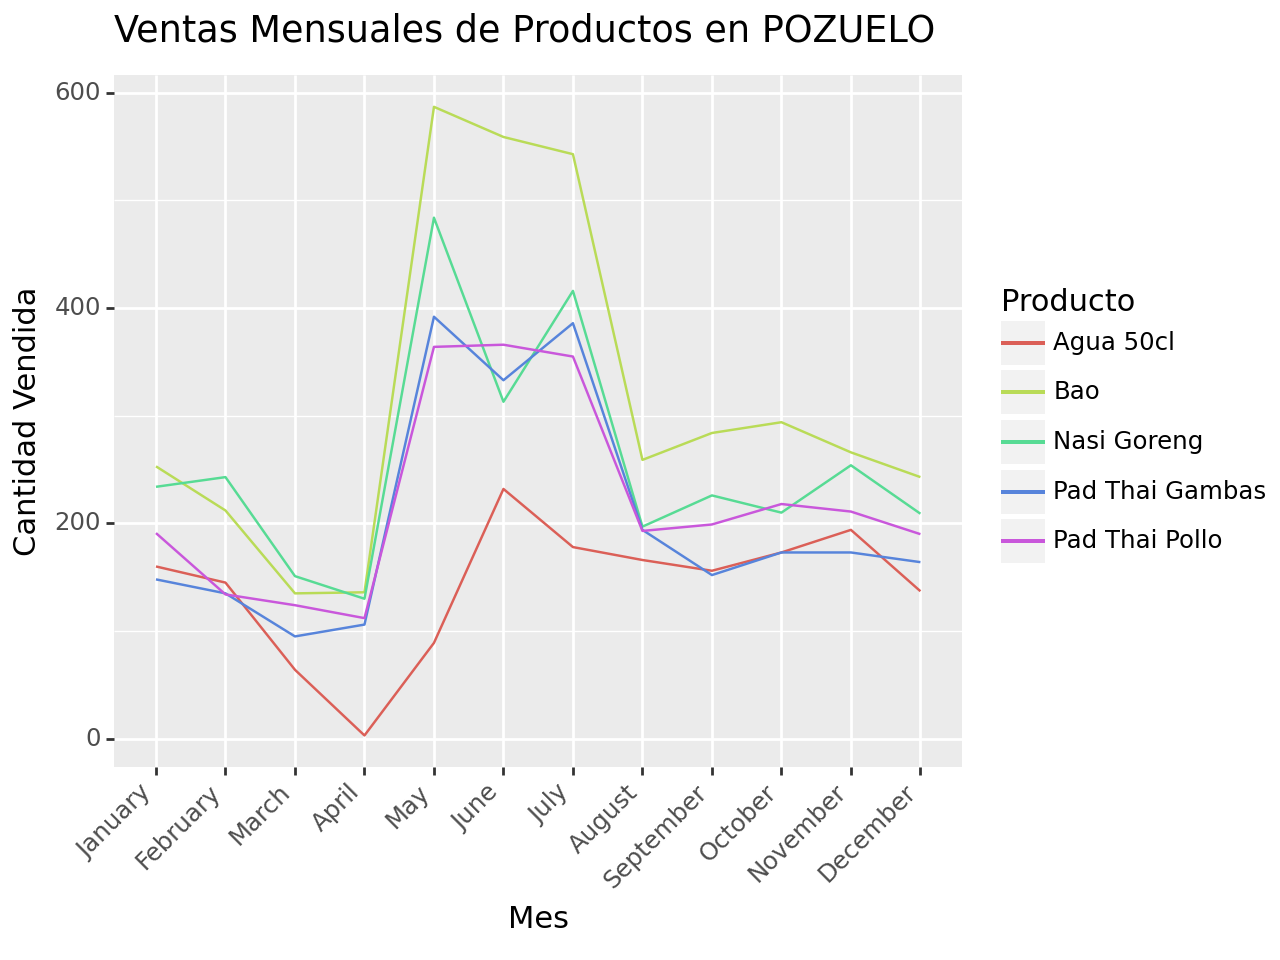

<ipython-input-66-61f9d7d703eb>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


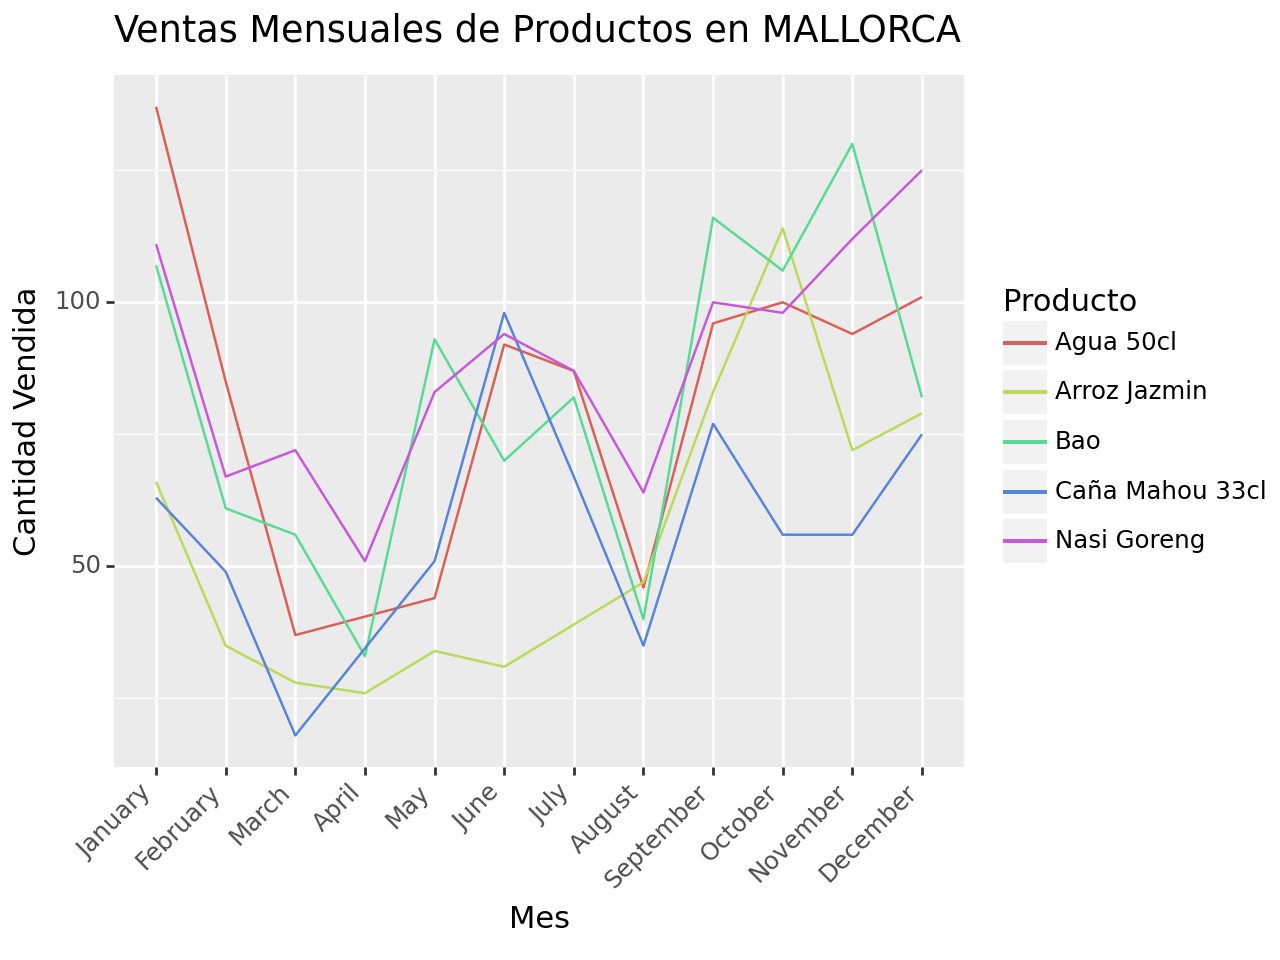

<ipython-input-66-61f9d7d703eb>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


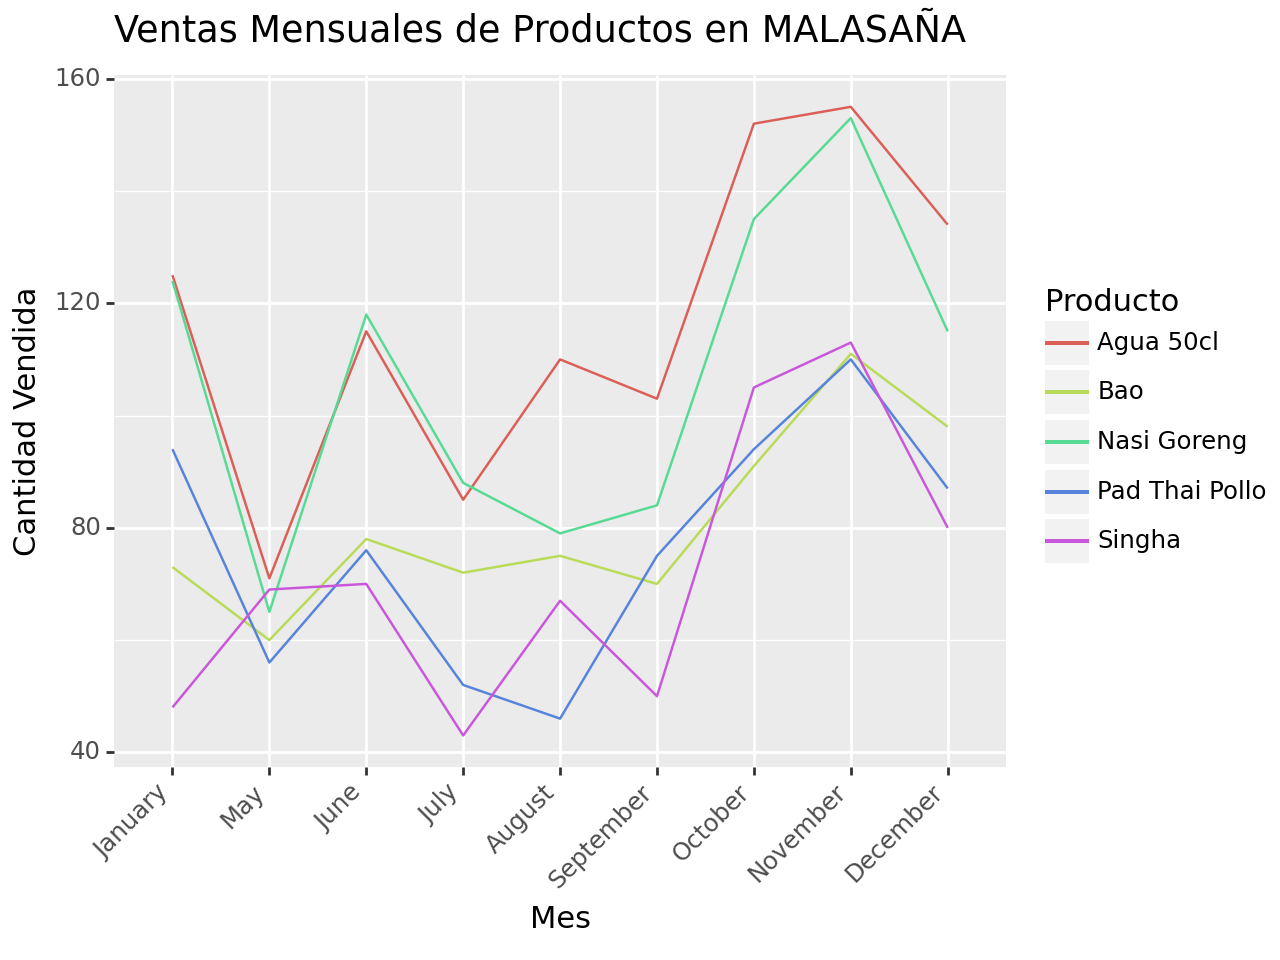

<ipython-input-66-61f9d7d703eb>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


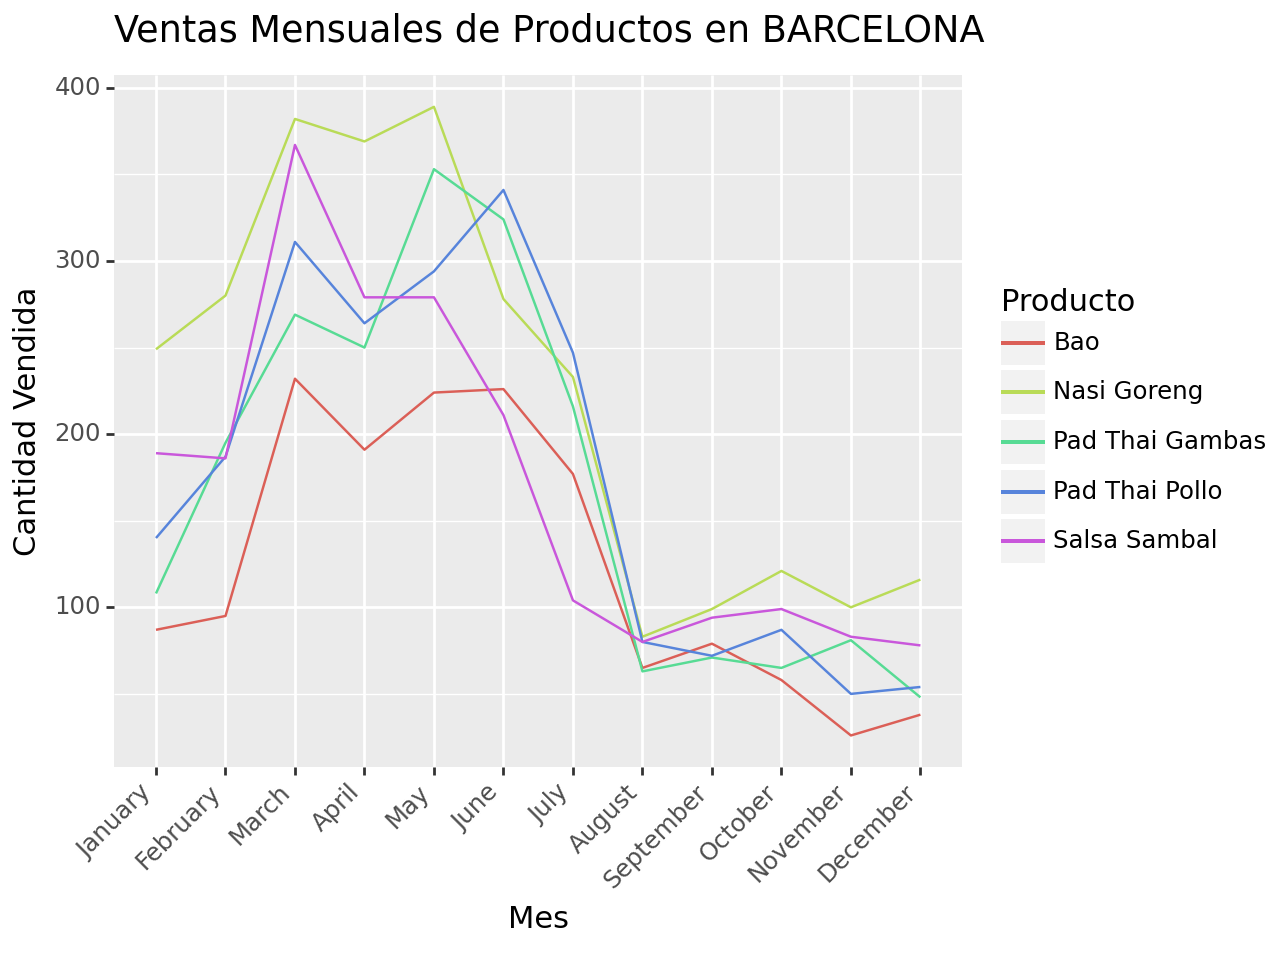

In [66]:
# Agrupamos por Local, Producto y mes para calcular las ventas

ventas_mensuales = data.groupby(["Local", "Producto", "nombre_mes"], as_index=False)\
    .agg(CantidadVendida=("Producto", "size"))

months_order = ["January", "February", "March", "April", "May", "June",\
              "July", "August", "September", "October", "November", "December"]

# Generamos a traves de un bucle los gráficos de ventas mensuales

for local in productos_mas_vendidos["Local"].unique():

    top_productos = productos_mas_vendidos\
        [productos_mas_vendidos["Local"] == local]["Producto"].tolist()

    # Filtrar las ventas mensuales y diarias para estos productos
    ventas_mensuales_local = ventas_mensuales\
        [(ventas_mensuales["Local" ]== local) & (ventas_mensuales["Producto"]\
                                                .isin(top_productos))]
    ventas_mensuales_local["nombre_mes"] = pd\
    .Categorical(ventas_mensuales_local["nombre_mes"], \
                 categories=months_order, ordered=True)

    ventas_mensuales_local = ventas_mensuales_local.sort_values("nombre_mes")

    # Graficar ventas mensuales
    plot_mensual = (ggplot(aes("nombre_mes","CantidadVendida", color="Producto")
                    , ventas_mensuales_local) +
                    geom_line(aes(group="Producto")) +
                    labs(title=f"Ventas Mensuales de Productos en {local}",
                         x="Mes", y="Cantidad Vendida") +
                    theme(axis_text_x=element_text(rotation=45, hjust=1)))

    print(plot_mensual)

Analicemos segun localidad:

1. Valencia: Vemos como tenemos picos a principio de año y a finales. El Agua vemos como tambien tiene un pico en los meses de verano lo cual tiene sentido debido al calor.
2. Pozuelo: Vemos como las ventas son similares a lo largo del año a excepcion del periodo Mayo->Julio donde tenemos los picos mas altos de cada producto.
3. Mallorca: Aqui podemos observar que hay distintos picos a lo largo del año, tenemos un pico al inicio en el mes de enero donde se registran las ventas mas altas de algunos productos como el agua. Luego tenemos otro pico en los meses de mayo/verano lo cual tiene sentido al ser un destino turistico de playa. Por ultimo tenemos el pico de los ultimo 2/3 meses del año registrando las ventas mas altas de productos como el Nasi Goreng , Bao y Arroz Jazmin.
4. Malasaña: Aqui faltan datos del periodo febrero->abril. Igual vemos como tenemos un pico notable a finales de año tambien registrando las ventas mas altas.
5. Barcelona: Vemos como se rompe un poco la tendencia de otras localidades al tenemos el mayor pico de ventas estable a lo largo de los primero 6 meses del año y luego a partir de Agosto las ventas se desploman.

Ahora pasemos a analizar por dia del mes:

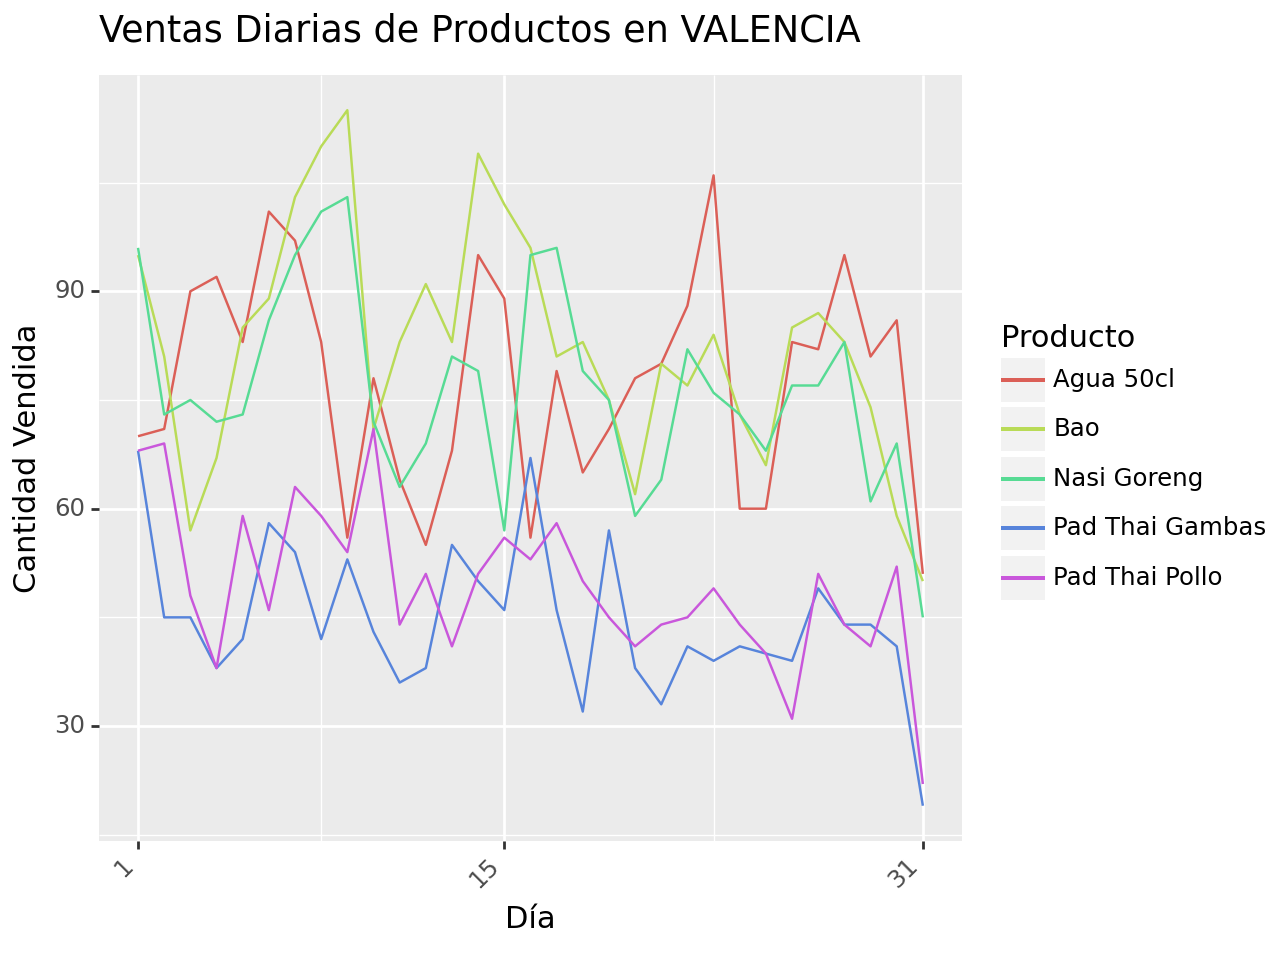

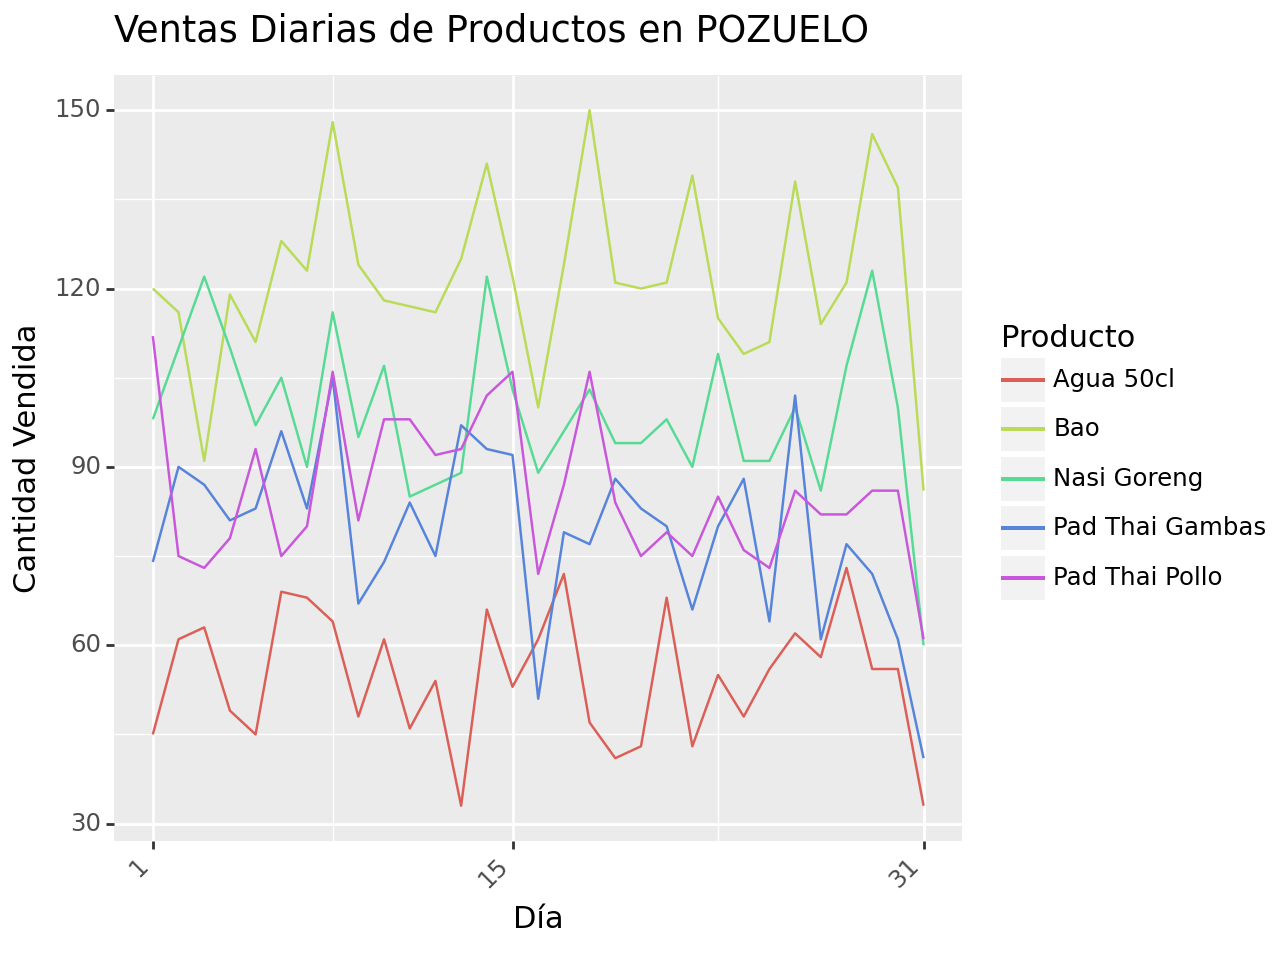

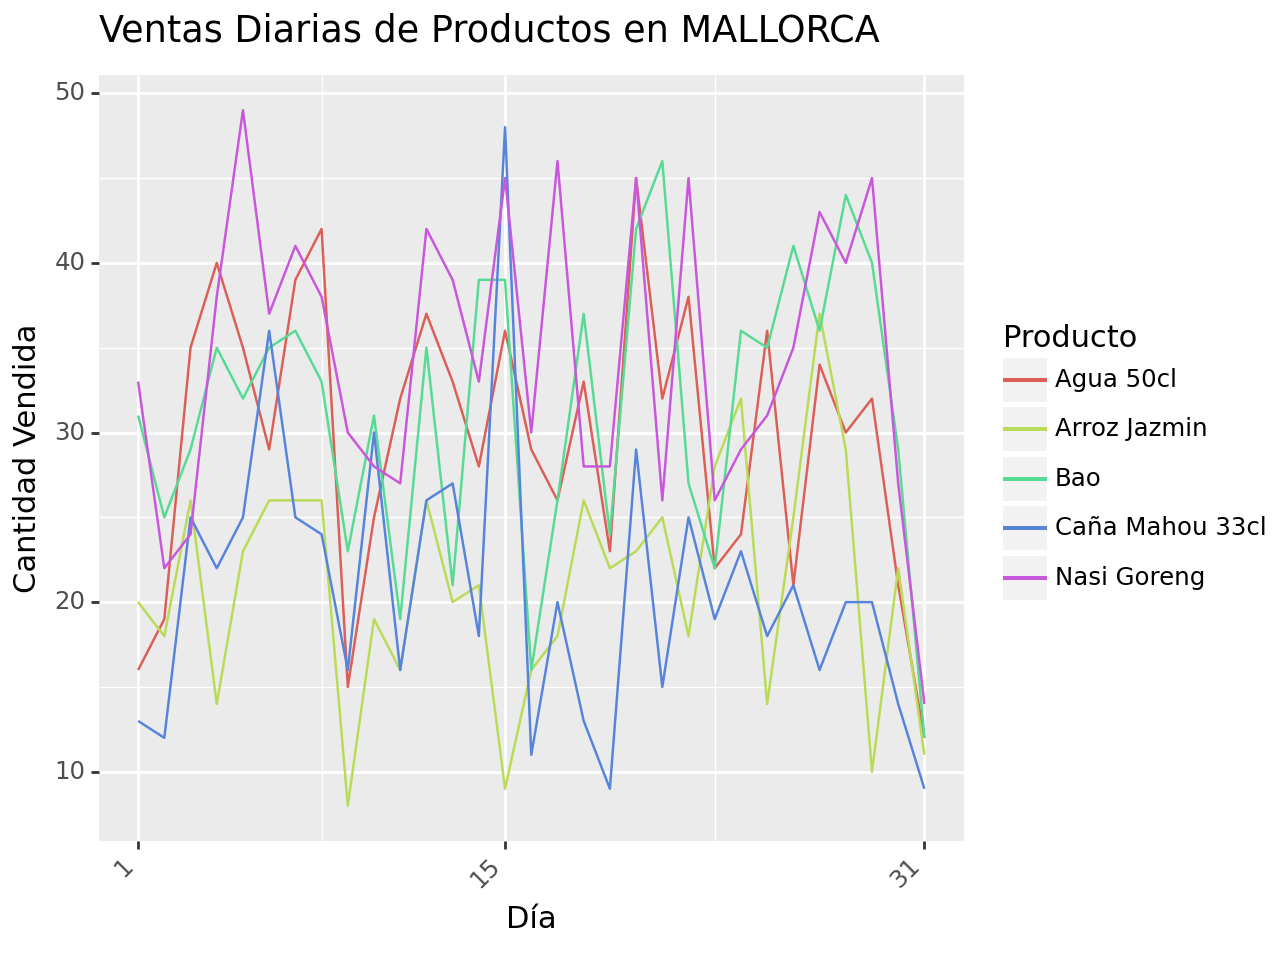

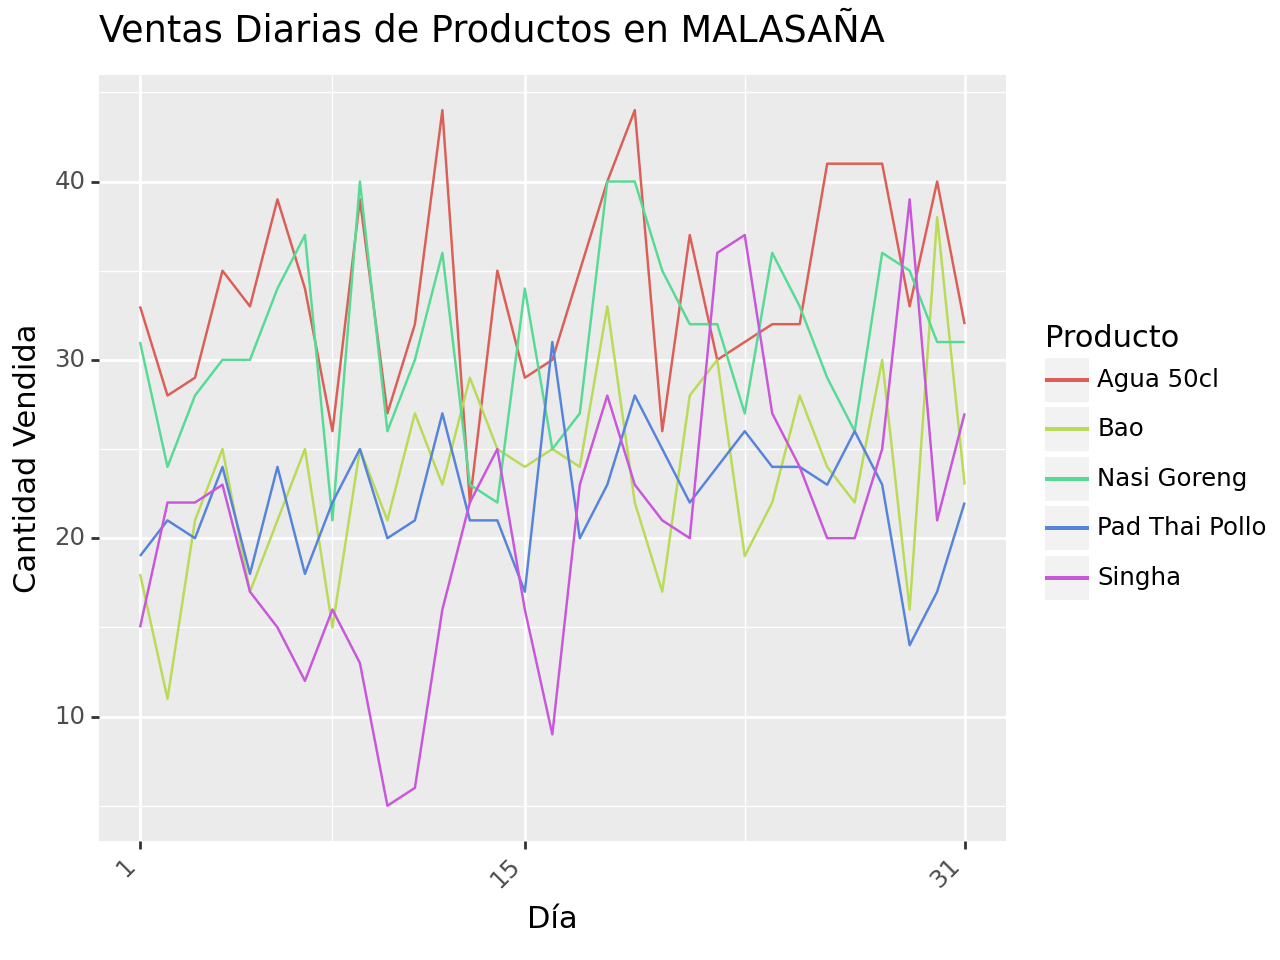

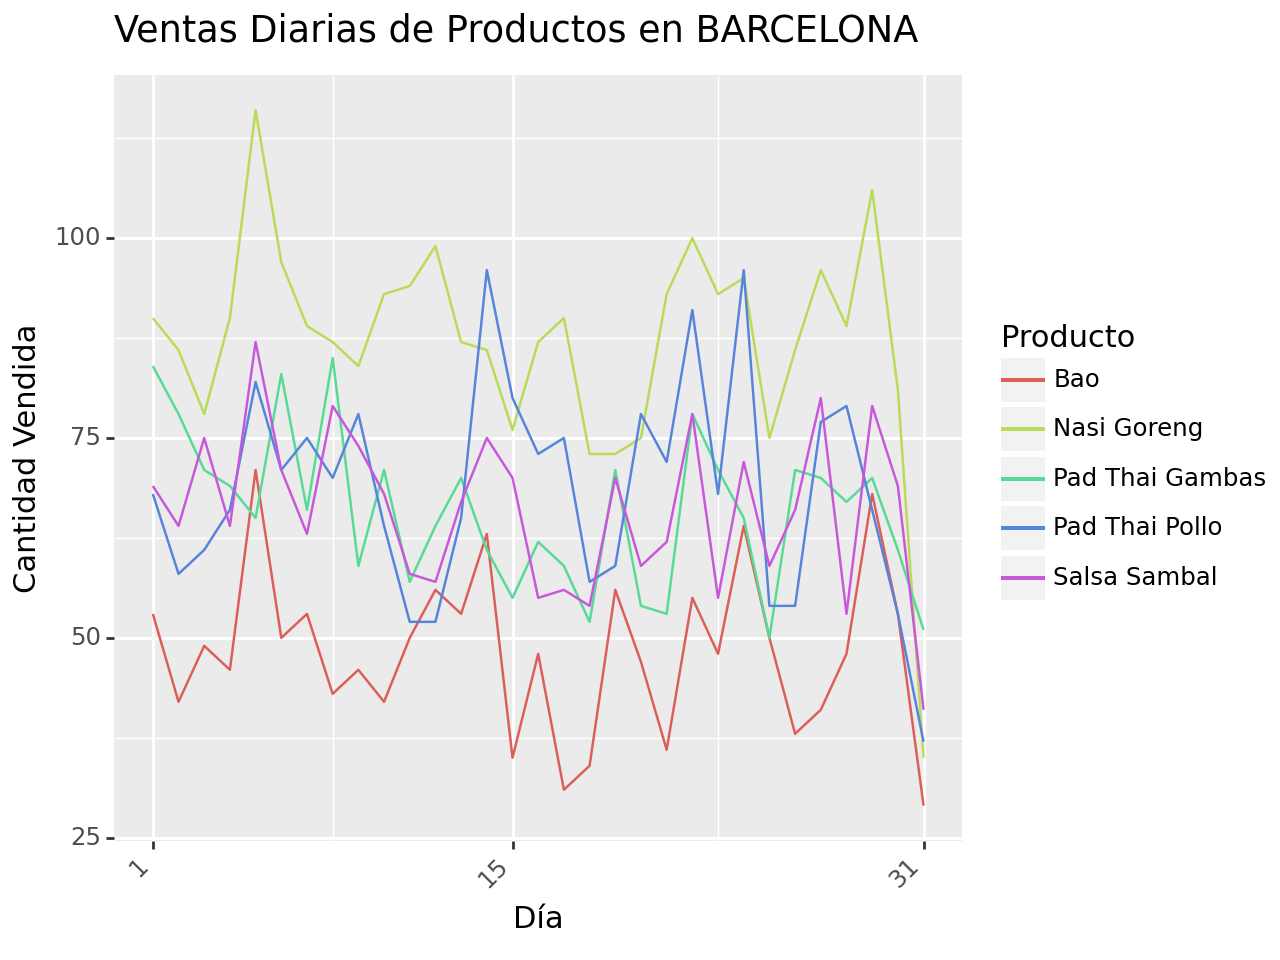

In [67]:
# Agrupamos por Local, Producto y dia  para calcular las ventas

ventas_diarias = data.groupby(["Local", "Producto", "dia"], as_index=False)\
    .agg(CantidadVendida=("Producto", "size"))

# Generamos los graficos de ventas diarias para los productos más vendidos
for local in productos_mas_vendidos["Local"].unique():

    top_productos = productos_mas_vendidos\
        [productos_mas_vendidos["Local"] == local]["Producto"].tolist()

    # Filtramos las ventas diarias para estos productos
    ventas_diarias_local = ventas_diarias\
    [(ventas_diarias["Local"]== local) & (ventas_diarias["Producto"]\
                                          .isin(top_productos))]

    grafica_diaria=(ggplot(aes("dia","CantidadVendida", color="Producto"),
                           ventas_diarias_local)\
    + geom_line()\
    + scale_x_continuous(breaks=[1, 15, 31], limits=(1, 31))\
    + labs(title=f"Ventas Diarias de Productos en {local}",\
         x="Día", y="Cantidad Vendida")\
    + theme(axis_text_x=element_text(rotation=45, hjust=1)))

    print(grafica_diaria)


Analicemos por Localidad:

1. Valencia: Vemos que hay una alta variabilidad en las ventas diarias de los productos. Los picos de ventas se distribuyen razonablemente a lo largo del mes sin una tendencia clara a favor de algún periodo específico. Podemos ver tambien que hay cierta consistencia en los picos durante el mes, indicando posibles días recurrentes de alta demanda.
2. Pozuelo: Vemos que las ventas diarias son similares a lo largo del mes, pero presentan picos más altos hacia los días a mediados y finales del mes.
3. Mallorca: Aqui podemos ver que las ventas tienen varios picos distribuidos a lo largo del mes. Los picos más altos se registran a principios y mediados de mes. La variabilidad en las ventas es alta debido al turismo.
4. Malasaña: Podemos observar que las ventas muestran una alta variabilidad, con picos en los días finales del mes. Se observa un patrón de demanda medio-alto hacia el final del mes
5. Barcelona: Vemos que presenta ventas estables a lo largo del mes pero con picos al inicio, mediados y final de mes. Tambien se nota como las ventas disminuyen en los ultimos dias del mes , a excepcion del Nasi Goren y Pad Thai Pollo.

##6.  Clientes Comunes:
¿Existen clientes que han realizado compras en más de una ubicación?
¿Cómo contribuyen estos clientes a las ventas totales y cuál es su comportamiento de compra en diferentes
ubicaciones?

Para responder a esta pregunta deberemos de añadir las columnas de CIF y Cliente nuevamente y verificar en cuales Localidades salen.

Por lo que creamos y limpiamos el dataset de nuevo pero sin elimnar dichas columnas y sin rellenar valores nulos para no distorsionar los datos.

In [68]:
# Concatenamos todos los datasets en uno para facilitar trabajo
data_clientes = pd.concat([barcelona,malasaña,mallorca,valencia,pozuelo],axis=0,\
                 ignore_index=True)

# Quitamos espacios entre nombre de las variables
data_clientes = data_clientes.rename(columns=lambda x: x.replace(' ', ''))

# Eliminamos variables que contengan alta cantida de valores na
data_clientes.drop(["CuentaContable","Ciudad","Provincia",\
          "Calle","CódigoPostal","GrupoMayor","Cód.Promoción","Cód.Descuento"],\
           axis=1, inplace=True)

# Eliminamos la variable No lo se
data_clientes = data_clientes[data_clientes["Producto"] != "No lo se"]

# Eliminamos caracteres innecesarios de variables
data_clientes["Local"] = data_clientes.Local.str.replace(r" \(\✔\)", "",\
                                                         regex=True)

# Eliminamos valores fuera de lo comun (probablemente errores)
data_clientes = data_clientes.sort_values("Total", ascending=False)
data_clientes.drop(data_clientes.index[:5], inplace=True)

Una vez limpiado, procedemos a filtrar e identifcar que CIF sale en mas de una localidad. Usamos el CIF y no Cliente ya que considero que con el CIF obtenemos los valores unicos.

In [69]:
clientes_unicos = data_clientes.groupby("CIF", as_index=False)\
.agg(TotalVeces=("Local","nunique"))

clientes_unicos = clientes_unicos.loc[clientes_unicos["TotalVeces"] > 1]

clientes_unicos

CIF  TotalVeces
66  B66362906           3

COmo vemos el cliente con el CIF B66362906 ha comprado en 3 Localidades distintas. Ahora analicemos su comportamiento

In [70]:
cif_cliente= clientes_unicos["CIF"]

comportamiento = data_clientes.loc[data_clientes.CIF.isin(cif_cliente)]

comportamiento = comportamiento\
    .groupby(["CIF", "Local", "FechaCreación"], as_index=False)\
    .agg(
    TotalGastado=("Total", "sum"),
    Cliente=("Cliente", "first"),
    Productos=("Producto", lambda x: list(x))
)

comportamiento

CIF      Local       FechaCreación  TotalGastado      Cliente  \
0  B66362906  BARCELONA 2019-05-03 15:23:00         11.25  Glovoapp R.   
1  B66362906   MALLORCA 2020-01-03 15:24:00         17.90   GlovoApp23   
2  B66362906    POZUELO 2019-11-17 23:01:00         12.20   GlovoApp23   

                                      Productos  
0               [Pad Thai Gambas, Salsa Sambal]  
1                   [Babi Ketjap, Arroz Jazmin]  
2  [Chungking Express, Agua 50cl, Salsa Sambal]

Podemos ver que este CIF compro bajo el nombre de 2 clientes (aunque por el nombre, probablemente sea el mismo solo que se haya registrado con nombres diferentes), en las localidades de Barcelona, Mallorca y Pozuelo en diferentes fechas  (dos veces en 2019 y una vez en 2020). Tambien podemos ver los productos que compro por lo que se supone que era para almuerzos y cenas.

## 7. Análisis Detallado del Comportamiento de Ventas:
7.1 Duración Promedio de las Transacciones:
¿Cuál es la duración promedio de una transacción? (Calcula la diferencia entre la fecha de creación y la fecha de venta).

In [71]:
data.horaIncio.value_counts()

horaIncio
0    171086
Name: count, dtype: int64

Como podemos ver no se puede realizar este apartado ya que la fecha de creacion las horas siempre son 00:00:00:00 por lo cual no tiene sentido realizar la resta ya que no daria un resultado realista



---


7.2 Ventas por Día de la Semana:
¿En qué día de la semana se realizan más ventas en promedio?






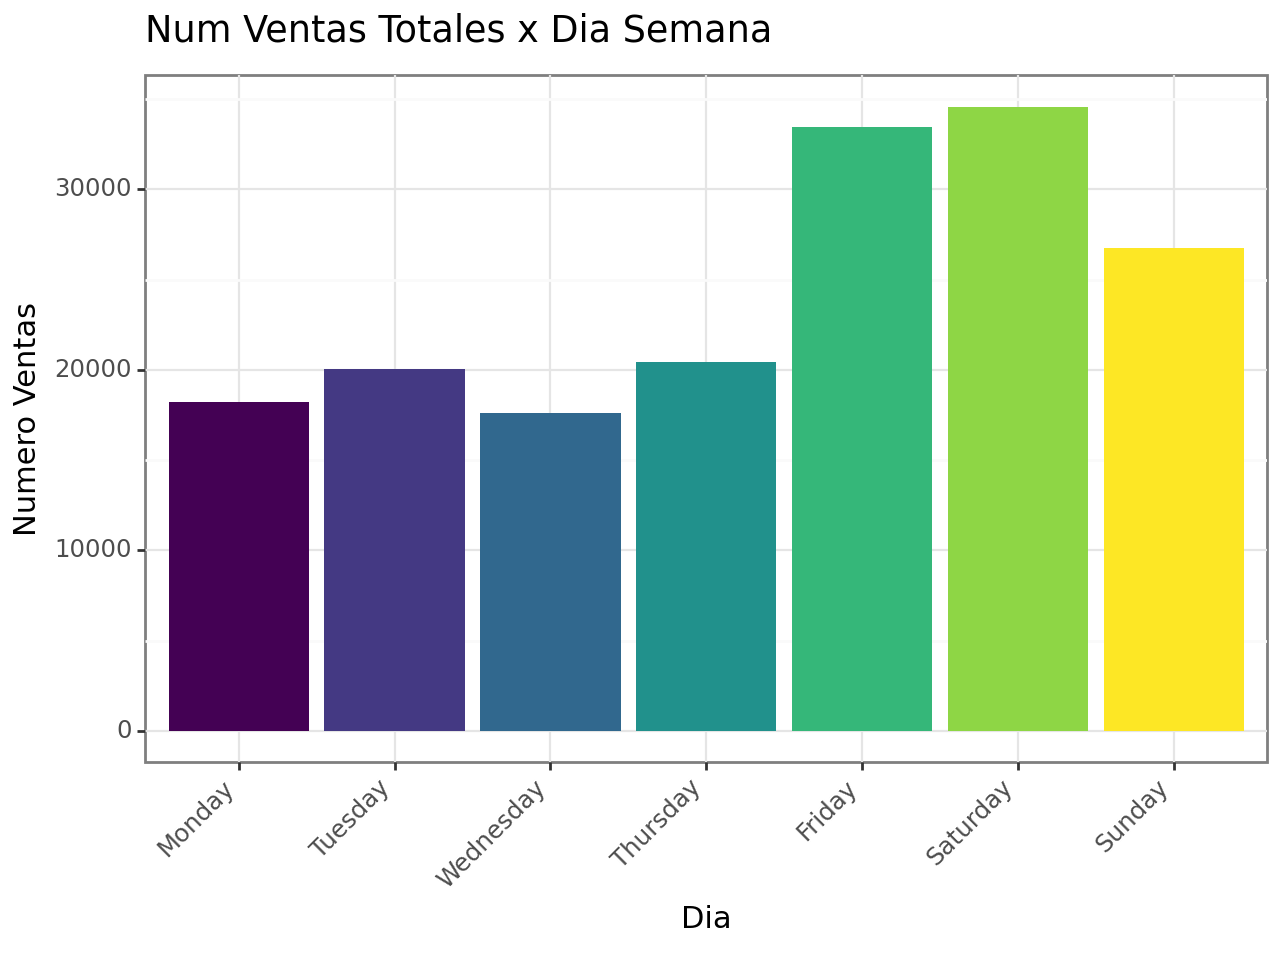

<Figure Size: (640 x 480)>

In [72]:
ventas_semana_total = data.loc[:,["Total","nombre_dia"]]\
    .groupby(["nombre_dia"], as_index=False)\
        .agg(VentasTotales=("Total","size"))

week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",\
              "Saturday", "Sunday"]

ventas_semana_total["nombre_dia"] = pd.Categorical(ventas_semana_total["nombre_dia"],\
                                            categories=week_order, ordered=True)

ggplot(aes("nombre_dia","VentasTotales",fill="nombre_dia"), ventas_semana_total)\
    +geom_bar(stat="identity")\
    +labs(title="Num Ventas Totales x Dia Semana",
         x="Dia",
         y="Numero Ventas")\
    +theme_bw()\
    +theme(legend_position="none")\
    +theme(axis_text_x=element_text(angle=45, hjust=1))

Viendo el numero de ventas por dia de la semana, podemos identificar el sabado como el dia donde mas ventas hay seguido cercanamente del viernes.





---


7.3Meses con Mayor y Menor Ventas:
¿Cuáles son los meses con las ventas más altas y más bajas?

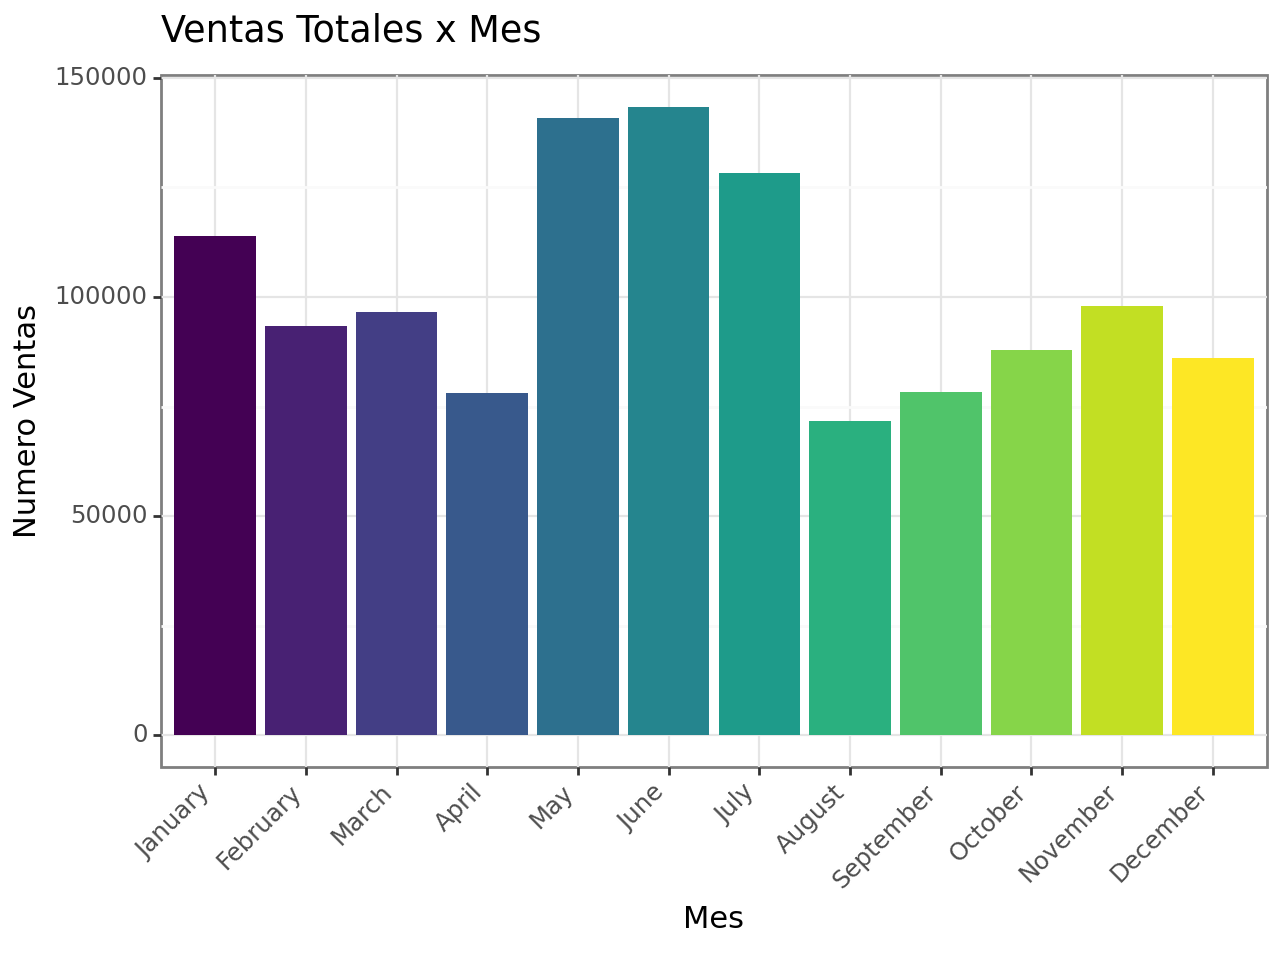

<Figure Size: (640 x 480)>

In [73]:
ventas_mes_total = data.loc[:,["Total","nombre_mes"]]\
    .groupby(["nombre_mes"], as_index=False)\
        .agg(VentasTotales=("Total","sum"))

months_order = ["January", "February", "March", "April", "May", "June",\
              "July", "August", "September", "October", "November", "December"]

ventas_mes_total["nombre_mes"] = pd.Categorical(ventas_mes_total["nombre_mes"], \
                                          categories=months_order, ordered=True)

ggplot(aes("nombre_mes","VentasTotales",fill="nombre_mes"), ventas_mes_total)\
    +geom_bar(stat="identity")\
    +labs(title="Ventas Totales x Mes",
         x="Mes",
         y="Numero Ventas")\
    +theme_bw()\
    +theme(legend_position="none")\
    +theme(axis_text_x=element_text(angle=45, hjust=1))

Podemos ver que los meses donde hay mas ventas son en Junio,Mayo y Julio.
Donde menos ventas hay es en Agosto, Septiembre y Abril



---


7.4 Descuentos Relativos:
¿Cuál es el porcentaje de descuento promedio en relación con el precio original de los productos?

**Como explique en el punto 3, considero que realizar cualquier estudio de descuentos es una perdida de tiempo ya que no tenemos datos suficientes para hacer una analsis realista.**









## 8. Preguntas adicionales:
8.1 Crear una columna que indique si una venta tuvo un descuento y que porcentaje de ventas tuvieron descuento? (REALIZADO EN EL APARTADO 3: ANALISIS DE DESCUENTOS)




---


8.2. Crear una columna de ganancia neta restando el costo de los productos al total


In [74]:
data["GananciaNeta"] = data.Total - (data.PrecioCoste*data.Cantidad)

data.GananciaNeta

Fecha
2019-12-19    720.00
2019-03-12    340.12
2019-02-02    420.00
2019-02-19    308.80
2019-02-26    346.94
               ...  
2019-02-07    -69.12
2019-01-17    -86.04
2019-07-02    -93.42
2019-12-23   -101.43
2019-07-02   -159.85
Name: GananciaNeta, Length: 171086, dtype: float64



---


8.3 Crear una columna que clasifique las ventas como "Alta", "Media" o "Baja" según el monto total

In [75]:
# Sacamos una referencia por la media de Total para hacer los grupos
data.Total.mean()
data["TipoVenta"] = pd.cut(data.Total, bins=[0,3.50,10.60,data.Total.max()], \
                         labels=["bajas","medias","altas"])

data.TipoVenta.value_counts()

TipoVenta
medias    79189
bajas     44929
altas     29515
Name: count, dtype: int64